# Predicting Student Success for Early Interventions


# Problem Statement:

The purpose of this project is to predict pass/fail of courses for early interventions that can help change student outcomes.  How early can we predict outcomes for intervention while still being reliable? Or how soon can we detect that a student is "slipping." 

# Get the data
In this section, we load the data from [this Kaggle dataset](https://www.kaggle.com/anlgrbz/student-demographics-online-education-dataoulad). We create 7 dataframes corresponding to the 7 csv files provided.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import os, glob
from os import makedirs
from sklearn.preprocessing import OneHotEncoder
from statsmodels.graphics.mosaicplot import mosaic
from itertools import product
# Models metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
# Algorithms
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import DistanceMetric

# Neural networks imports
# The code setting the seeds below is needed for reproducibility in neural networks
# The order is important. Do no change the order.
import tensorflow as tf
import random as python_random

# Numpy generated random numbers seed
np.random.seed(123)

# Python generated random numbers seed
python_random.seed(123)

# Tensorflow random number generation seed
tf.random.set_seed(1234)

# Import keras for neural networks after set up seeds
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model

In [4]:
courses = pd.read_csv('data/courses.csv')
assessments = pd.read_csv('data/assessments.csv')
s_assessments = pd.read_csv('data/studentAssessment.csv')
student_info = pd.read_csv('data/studentInfo.csv')
student_reg = pd.read_csv('data/studentRegistration.csv')
s_vle = pd.read_csv('data/studentVle.csv')
vle = pd.read_csv('data/vle.csv')

# Exploration of Data Tables
In this section, we summarize the contents of each table and include some basic summary statistics.

## Courses

- code_module: ID of the course (one of 7)
- code_presentation: Year and term (eg. 2013J)
- module_presentation_length: length of the term (some terms are shorter than others)

In [23]:
courses.head()

,code_module,code_presentation,module_presentation_length,cutoff_date,cutoff_percent
0,AAA,2013J,268,134.0,50
1,AAA,2014J,269,134.5,50
2,BBB,2013J,268,134.0,50
3,BBB,2014J,262,131.0,50
4,BBB,2013B,240,120.0,50


## Assessments

- code_module, code_presentation: see above
- id_assessment: unique id for each assessment; TMA = Tutor Marked Assessment (manually graded), CMA = Computer Marked Assessment (autograded), other (Exam - unclear how graded)
- date: days between start of module and final submission
- weight: percentage of grade; note that Exams are treated separately and weighted 100% (so functionally each course has 200%)


In [6]:
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


## Student Assessments
- id_assessment, id_student: see above
- date_submitted: date the student submitted the assessment 
- is_banked: indicates that the assessment grade has been transferred from a previous presentation (presumably if the student failed or withdrew and then retook?
- score: range from 0-100, 40 is considered a failing grade

In [7]:
s_assessments.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


## Student Info

- code_module, code_presentation: see above
- id_student: unique student id
- gender: M/F
- region: all UK/Ireland
- higest_education: UK terms - A level, lower than a level, he qualification, etc.
- imd band: a measure of poverty associated with the region ( [multiple deprivation index](https://en.wikipedia.org/wiki/Multiple_deprivation_index))
- age_band: very wide! 0-35, 35-55, other
- num_of_prev_attempts: number of times a student has attempted a course
- studied_credits: total number of credits for courses a student is taking

In [8]:
student_info.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [9]:
student_info.region.unique()

array(['East Anglian Region', 'Scotland', 'North Western Region',
       'South East Region', 'West Midlands Region', 'Wales',
       'North Region', 'South Region', 'Ireland', 'South West Region',
       'East Midlands Region', 'Yorkshire Region', 'London Region'],
      dtype=object)

In [10]:
student_info.highest_education.unique()

array(['HE Qualification', 'A Level or Equivalent', 'Lower Than A Level',
       'Post Graduate Qualification', 'No Formal quals'], dtype=object)

## Student Registration

- code_module, code_presentation, id_student: see above
- date_registration: the number of days in advance that the student registered for the term (negative numbers)
- date_unregistration: the days after the start of class that the student dropped the class

In [11]:
student_reg.head()

,code_module,code_presentation,id_student,date_registration,date_unregistration
0,AAA,2013J,11391,-159.0,NaN
1,AAA,2013J,28400,-53.0,NaN
2,AAA,2013J,30268,-92.0,12.0
3,AAA,2013J,31604,-52.0,NaN
4,AAA,2013J,32885,-176.0,NaN


## Student VLE

- code_module, code_presentation, id_student: see above
- id_site: identification number for the specific VLE page (see VLE file for details on type)
- date: number of days after the start of the course that the student interacted with that page
- sum_click - the number of times the student clicks on that specific page that day

notes: sum the total number of clicks per student per day, regardless of page?

In [12]:
s_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [13]:
# Variable : first_click
#Find minimum of absolute value of date and group by id_student, code_module, code_presentation for days to first click since course start  
s_vle['first_click'] = s_vle.groupby(['id_student', 'code_module', 'code_presentation'])['date'].transform(abs).min()
s_vle['first_click'].max()
# is 0, everyone clicks into the module on the first day? 

0

## VLE (Virtual Learning Environment)

- id_site, code_module, code_presentation: see above
- activity_type: what is hosted on this page of the VLE (such as resource, url, subpage, quiz, etc.)
- week_from and week_to: the weeks that the material would be used. For example, if material is just for week 2, this would be 2, 2. If the material is used for multiple weeks, it could be something like 4, 8. For most material, these fields are left blank or week_from = week_to.

Notes:
join with student vle data to be able to group by activity_type

In [14]:
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


In [15]:
vle.activity_type.unique()

array(['resource', 'oucontent', 'url', 'homepage', 'subpage', 'glossary',
       'forumng', 'oucollaborate', 'dataplus', 'quiz', 'ouelluminate',
       'sharedsubpage', 'questionnaire', 'page', 'externalquiz', 'ouwiki',
       'dualpane', 'repeatactivity', 'folder', 'htmlactivity'],
      dtype=object)

# Time Cutoffs function
In this section, we create a function that filters the data to student activity that occurs within a given timeframe. Using an input that corresponds to the desired percentage of the semester included, the function filters the courses, s_vle, assessments, and s_assessments datasets.

For our purposes, we are interested in creating a model that effectively predicts student outcomes halfway through the semester.

At the end of this section, we end up with new s_vle and s_assessment dataframes that only include student activity and grades until the 50% point of their respective semester.

In [16]:
# a function to cut the s_vle dataset down using a time parameter
# the 'cutoff' parameter is a percentage value, autoset to include the full module

def time_cutoff(courses, s_vle, assessments, s_assessments, cutoff=100):
  # course_data should be set to 'courses'
  # vle_data should be set to 's_vle'

  # add new column formatted with time input that is the number of days cutoff for that course
  courses['cutoff_date'] = courses['module_presentation_length'] * (cutoff/100)
  courses['cutoff_percent'] = cutoff
  # add column to s_vle that includes the new cutoff date, based on the module and semester
  svle_2 = pd.merge(s_vle, courses, how='left', left_on=['code_module','code_presentation'], right_on=['code_module', 'code_presentation'])
  # filter out rows that measure clicks beyond the cutoff date
  svle_cutoff = svle_2[svle_2['date'] <= svle_2['cutoff_date']]

  # merge assessments and s_assessments dfs
  test2 = pd.merge(assessments, s_assessments, how='left', on='id_assessment')
  # add cutoff date to df
  test3 = pd.merge(test2, courses, how='left', left_on=['code_module','code_presentation'], right_on=['code_module', 'code_presentation'])
  # filter out tests submitted after the cutoff date
  assessments_cutoff = test3[test3['date_submitted'] <= test3['cutoff_date']]

  return svle_cutoff, assessments_cutoff

# EXAMPLE:
# following line will return 2 datasets. 'a' is the s_vle data for the first 10% of each module. 'b' is the student assessment data for first 10%.
# a,b = time_cutoff(courses, s_vle, assessments, s_assessments, 10)

Setting a changeable line of code to test different cutoffs.

In [17]:
s_vle, student_assessments = time_cutoff(courses, s_vle, assessments, s_assessments, 50)

In [18]:
s_vle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click,first_click,module_presentation_length,cutoff_date,cutoff_percent
0,AAA,2013J,28400,546652,-10,4,0,268,134.0,50
1,AAA,2013J,28400,546652,-10,1,0,268,134.0,50
2,AAA,2013J,28400,546652,-10,1,0,268,134.0,50
3,AAA,2013J,28400,546614,-10,11,0,268,134.0,50
4,AAA,2013J,28400,546714,-10,1,0,268,134.0,50


In [19]:
student_assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,module_presentation_length,cutoff_date,cutoff_percent
0,AAA,2013J,1752,TMA,19.0,10.0,11391.0,18.0,0.0,78.0,268,134.0,50
1,AAA,2013J,1752,TMA,19.0,10.0,28400.0,22.0,0.0,70.0,268,134.0,50
2,AAA,2013J,1752,TMA,19.0,10.0,31604.0,17.0,0.0,72.0,268,134.0,50
3,AAA,2013J,1752,TMA,19.0,10.0,32885.0,26.0,0.0,69.0,268,134.0,50
4,AAA,2013J,1752,TMA,19.0,10.0,38053.0,19.0,0.0,79.0,268,134.0,50


In [20]:
student_assessments['score'].unique()

array([ 78.,  70.,  72.,  69.,  79.,  71.,  68.,  73.,  67.,  83.,  66.,
        59.,  82.,  60.,  75.,  74.,  62.,  63.,  84.,  80.,  76.,  85.,
        57.,  81.,  87.,  77.,  45.,  65.,  61.,  52.,  54.,  51.,  88.,
        58.,  64.,  55.,  38.,  91.,  47.,  89.,  36.,  86.,  49.,  53.,
        39.,  nan,  90.,  50.,  56.,  30.,  11.,  40.,  94.,  48.,  46.,
        25.,  34.,  42.,  18.,  37.,  28.,  33.,  95.,  35.,  44.,  41.,
        15.,   0.,  43.,  24.,  19.,  27.,  32.,  29.,  20.,  92., 100.,
        93.,  97.,  23.,  99.,  98.,  10.,   5.,  13.,  26.,  22.,   8.,
        12.,  16.,   9.,  96.,  31.,   6.,   1.,  17.,   4.,   7.,   2.,
        14.,  21.,   3.])

In [21]:
student_assessments['score'].isnull().any()

True

# Create main dataset
In this section we are going to build our main dataset. We start from the `student_info` table and add some registration information from the `student_reg` table.

In [22]:
dataset = pd.merge(student_info, student_reg, how='left', left_on=['id_student', 'code_module','code_presentation'], right_on=['id_student', 'code_module', 'code_presentation'])
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0


## Drop rows of students that withdrawn before the semester started

In [ ]:
# Make a filter to check the rows that satisfy the condition
dataset[dataset['date_unregistration']<=0]

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration
125,AAA,2013J,292923,F,South East Region,A Level or Equivalent,90-100%,35-55,0,180,N,Withdrawn,-162.0,-121.0
136,AAA,2013J,305539,F,Wales,Lower Than A Level,80-90%,0-35,0,120,N,Withdrawn,-54.0,-3.0
198,AAA,2013J,405961,M,Scotland,A Level or Equivalent,90-100%,0-35,0,240,Y,Withdrawn,-170.0,-100.0
256,AAA,2013J,1763015,F,Scotland,A Level or Equivalent,10-20,35-55,0,60,N,Withdrawn,-58.0,-2.0
298,AAA,2013J,2318055,M,Wales,A Level or Equivalent,90-100%,35-55,0,60,N,Withdrawn,-56.0,-19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32344,GGG,2014J,679405,F,East Anglian Region,Lower Than A Level,40-50%,0-35,0,30,N,Withdrawn,-79.0,-66.0
32424,GGG,2014J,685877,M,East Anglian Region,Lower Than A Level,30-40%,35-55,0,30,Y,Withdrawn,-58.0,-58.0
32436,GGG,2014J,686898,F,East Anglian Region,Lower Than A Level,30-40%,0-35,0,120,N,Withdrawn,-2.0,-1.0
32441,GGG,2014J,687143,F,West Midlands Region,A Level or Equivalent,10-20,0-35,0,30,N,Withdrawn,-23.0,-3.0


In [ ]:
# Drop these rows from the dataset
dataset.drop(dataset[dataset['date_unregistration']<=0].index, inplace=True)

In [ ]:
# we dropped 3097 rows (32,593-29,496)
dataset.shape

(29496, 14)

## Variables Manipulation

**Added variables**
- cutoff_percent: the percentage of the student vle and assessments data that is included (e.g. 10%, 100%, etc)
- cutoff_date: the last date that is included in the student vle and assessments data, measured in days after start of term
- sum_click: the number of VLE clicks per student for a given presentation of a module
- sum_days: the total number of days that a student interacted with the module in the VLE during the term
- percent_click: the percentage of days (during the semester) that a student clicked into the VLE at least X number of times (auto set to 1) **confirmed**
- avg_grade: the numerical grade of a student's performance on assessments (note: this average does not take weighting into consideration)
- avg_clicks: the average number of clicks per day *(note: only considers active days - should we include days with 0 clicks?)*
- imd_digit: numerical digit associated with the lower end of the imd band

**Categorical variables**
- click_group: bins of the sum_click variable 

  * ['0-1000','1000-2000','2000-3000','3000-4000','4000-5000','5000-6000', 
'6000-7000','7000-8000','8000-9000','9000-10000','>10000']
- days_group: bins of the sum_days variable
  * ['0-25','25-50','50-75','75-100','100-125','125-150','150-175','175-200','200-225','225-250','250-275','>275']
- credit_group: bins of the studied_credit variable
  * ['0-50','50-100','100-150','150-200','200-300','>300']
- avg_clicks_group: bins of the avg_clicks variable
  * ['0-10','10-20','20-30','30-40','40-50','50+']
- avg_grade_group: bins of the avg_grade variable
  * ['Not available', '0','1-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100']


### Number of clicks variable (sum_click)

In [ ]:
# Get the total number of clicks a student makes in a specific module and semester
group_by_click = s_vle.groupby([s_vle.code_module, s_vle.code_presentation, s_vle.id_student]).sum_click.sum()

# Remove the hierarchical index to get a standard table
group_by_click = group_by_click.reset_index()
group_by_click

,code_module,code_presentation,id_student,sum_click
0,AAA,2013J,11391,710
1,AAA,2013J,28400,986
2,AAA,2013J,30268,281
3,AAA,2013J,31604,1382
4,AAA,2013J,32885,799
...,...,...,...,...
29199,GGG,2014J,2640965,41
29200,GGG,2014J,2645731,304
29201,GGG,2014J,2648187,132
29202,GGG,2014J,2679821,275


In [ ]:
# Add the sum_click variable to the main dataset
dataset = pd.merge(dataset, group_by_click, how='left', on=['code_module', 'code_presentation', 'id_student'])
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,710.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,986.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,281.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,1382.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,799.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN,41.0
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN,304.0
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN,132.0
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0,275.0


#### Categorical variable from the sum_click variable (click_group)

In [ ]:
dataset.sum_click.max()

14572.0

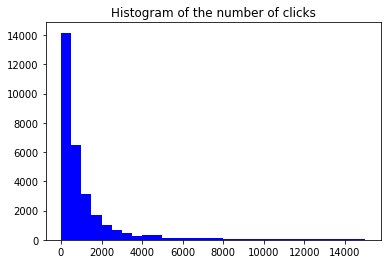

In [ ]:
# The sum_click variable goes from 0 to 14,572
plt.hist(dataset.sum_click, color='blue', bins=[0,500,1000,1500,2000,2500,3000,3500,4000,5000,6000,8000,15000])
plt.title('Histogram of the number of clicks')
plt.show()

In [ ]:
# Create a categorical variable based on the sum_click variable
category = pd.cut(dataset.sum_click,bins=[0,500,1000,1500,2000,2500,3000,3500,4000,5000,6000,8000,15000],labels=['0-500','500-1000','1000-1500','1500-2000','2000-2500',
                                                                                                                 '2500-3000','3000-3500','3500-4000','4000-5000',
                                                                                                                 '5000-6000','6000-8000','>8000'],
                  include_lowest=True)
dataset.insert(15,'click_group',category)
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,click_group
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,710.0,500-1000
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,986.0,500-1000
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,281.0,0-500
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,1382.0,1000-1500
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,799.0,500-1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN,41.0,0-500
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN,304.0,0-500
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN,132.0,0-500
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0,275.0,0-500


### Number of days variable (sum_days)


In [ ]:
# Get the total number of days a student interacted with a specific module in a semester
# nunique() function returns the number of unique elements in the object. It returns a scalar value which is the count of all the unique values
# In this case unique dates
group_by_days = s_vle.groupby([s_vle.code_module, s_vle.code_presentation, s_vle.id_student]).date.nunique()

# Remove the hierarchical index to get a standard table
group_by_days = group_by_days.reset_index()

# Add the sum_click variables
dataset = pd.merge(dataset, group_by_days, how='left', on=['code_module', 'code_presentation', 'id_student'])

# Give a more meaningful name to this column
dataset = dataset.rename(columns={'date': 'sum_days'})
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,710.0,500-1000,29.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,986.0,500-1000,50.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,281.0,0-500,12.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,1382.0,1000-1500,75.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,799.0,500-1000,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN,41.0,0-500,5.0
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN,304.0,0-500,18.0
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN,132.0,0-500,11.0
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0,275.0,0-500,13.0


#### Categorical variable for the sum_days variable (days_group)

In [ ]:
dataset.sum_days.max()

157.0

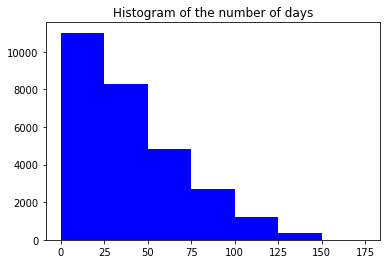

In [ ]:
# The sum_days variable goes from 0 to 157
plt.hist(dataset.sum_days, color='blue', bins=[0,25,50,75,100,125,150,175])
plt.title('Histogram of the number of days')
plt.show()

In [ ]:
category = pd.cut(dataset.sum_days,bins=[0,25,50,75,100,125,150,175],labels=['0-25','25-50','50-75','75-100','100-125','125-150','>150'], 
                  include_lowest=True)
dataset.insert(17,'days_group',category)
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days,days_group
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,710.0,500-1000,29.0,25-50
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,986.0,500-1000,50.0,25-50
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,281.0,0-500,12.0,0-25
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,1382.0,1000-1500,75.0,50-75
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,799.0,500-1000,47.0,25-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN,41.0,0-500,5.0,0-25
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN,304.0,0-500,18.0,0-25
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN,132.0,0-500,11.0,0-25
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0,275.0,0-500,13.0,0-25


### percent_clicks


In [ ]:
def percent_clicks_var(student_vle, clicks_min=1):

  semester_vle = student_vle[(student_vle['date'] >= 0) & (student_vle['date'] <= student_vle['module_presentation_length'])]
  semester_clicks = semester_vle.groupby(['code_module','code_presentation', 'cutoff_date', 'id_student', 'date'])[['sum_click']].sum().reset_index()
  semester_min = semester_clicks[(semester_clicks['sum_click'] >= clicks_min)]

  countofdays = semester_min.groupby(['code_module','code_presentation', 'cutoff_date', 'id_student'])[['date']].count().reset_index().rename(columns={'date': 'days_with_clicks'})

  countofdays['percent_clicks'] = (countofdays['days_with_clicks']/(countofdays['cutoff_date']+1))*100
  
  return countofdays

In [ ]:
countofdays = percent_clicks_var(s_vle)


In [ ]:
dataset = pd.merge(dataset,countofdays[['code_module','code_presentation', 'id_student','percent_clicks']], left_on=['id_student', 'code_module','code_presentation'], right_on=['id_student', 'code_module', 'code_presentation'], how='left')
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days,days_group,percent_clicks
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,710.0,500-1000,29.0,25-50,20.740741
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,986.0,500-1000,50.0,25-50,31.851852
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,281.0,0-500,12.0,0-25,4.444444
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,1382.0,1000-1500,75.0,50-75,51.851852
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,799.0,500-1000,47.0,25-50,28.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN,41.0,0-500,5.0,0-25,2.952030
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN,304.0,0-500,18.0,0-25,13.284133
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN,132.0,0-500,11.0,0-25,7.380074
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0,275.0,0-500,13.0,0-25,8.118081


In [ ]:
dataset = dataset.fillna(value={'percent_clicks': 0})

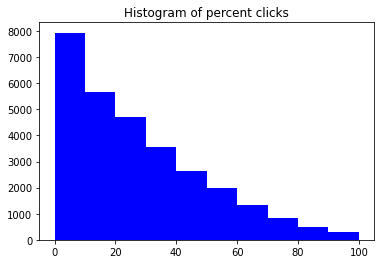

In [ ]:
plt.hist(dataset.percent_clicks, color='blue', bins=[0,10,20,30,40,50,60,70,80,90,100])
plt.title('Histogram of percent clicks')
plt.show()

In [ ]:
category = pd.cut(dataset.percent_clicks,bins=[0,10,20,30,40,50,60,70,80,90,100],labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90',
                                                                                                 '90-100'], include_lowest=True)
dataset.insert(17,'percentclicks_group',category)
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days,percentclicks_group,days_group,percent_clicks
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,710.0,500-1000,29.0,20-30,25-50,20.740741
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,986.0,500-1000,50.0,30-40,25-50,31.851852
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,281.0,0-500,12.0,0-10,0-25,4.444444
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,1382.0,1000-1500,75.0,50-60,50-75,51.851852
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,799.0,500-1000,47.0,20-30,25-50,28.888889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN,41.0,0-500,5.0,0-10,0-25,2.952030
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN,304.0,0-500,18.0,10-20,0-25,13.284133
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN,132.0,0-500,11.0,0-10,0-25,7.380074
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0,275.0,0-500,13.0,0-10,0-25,8.118081


### avg_grade, avg_grade_group

In [ ]:
dataset.columns

Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result', 'date_registration',
       'date_unregistration', 'sum_click', 'click_group', 'sum_days',
       'percentclicks_group', 'days_group', 'percent_clicks'],
      dtype='object')

In [ ]:
student_assessments.columns

Index(['code_module', 'code_presentation', 'id_assessment', 'assessment_type',
       'date', 'weight', 'id_student', 'date_submitted', 'is_banked', 'score',
       'module_presentation_length', 'cutoff_date', 'cutoff_percent'],
      dtype='object')

In [ ]:
student_assessments

,code_module,code_presentation,id_assessment,assessment_type,date,weight,id_student,date_submitted,is_banked,score,module_presentation_length,cutoff_date,cutoff_percent
0,AAA,2013J,1752,TMA,19.0,10.0,11391.0,18.0,0.0,78.0,268,134.0,50
1,AAA,2013J,1752,TMA,19.0,10.0,28400.0,22.0,0.0,70.0,268,134.0,50
2,AAA,2013J,1752,TMA,19.0,10.0,31604.0,17.0,0.0,72.0,268,134.0,50
3,AAA,2013J,1752,TMA,19.0,10.0,32885.0,26.0,0.0,69.0,268,134.0,50
4,AAA,2013J,1752,TMA,19.0,10.0,38053.0,19.0,0.0,79.0,268,134.0,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173426,GGG,2014J,37436,TMA,124.0,0.0,2645731.0,121.0,0.0,81.0,269,134.5,50
173427,GGG,2014J,37436,TMA,124.0,0.0,2648187.0,106.0,0.0,75.0,269,134.5,50
173428,GGG,2014J,37436,TMA,124.0,0.0,2684003.0,114.0,0.0,80.0,269,134.5,50
173761,GGG,2014J,37437,TMA,173.0,0.0,624767.0,-1.0,1.0,75.0,269,134.5,50


In [ ]:
student_assessments['score'].isnull().any()

True

In [ ]:
by_student_grade = student_assessments.groupby(['code_module','code_presentation','id_student'])['score'].mean()
by_student_grade = by_student_grade.reset_index()

In [ ]:
by_student_grade['score'].mean()

73.82512009995912

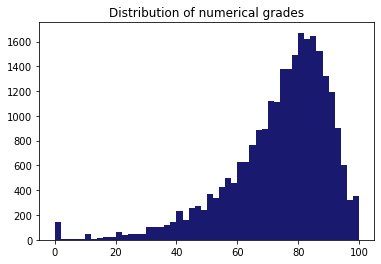

In [ ]:
plt.hist(by_student_grade.score, color='midnightblue', bins=50)
plt.title('Distribution of numerical grades')
plt.show()

In [ ]:
by_student_grade['score'].isnull().any()

True

In [ ]:
dataset = pd.merge(dataset, by_student_grade, how='left', on=['code_module', 'code_presentation', 'id_student'])
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days,percentclicks_group,days_group,percent_clicks,score
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,710.0,500-1000,29.0,20-30,25-50,20.740741,81.000000
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,986.0,500-1000,50.0,30-40,25-50,31.851852,69.333333
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,281.0,0-500,12.0,0-10,0-25,4.444444,NaN
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,1382.0,1000-1500,75.0,50-60,50-75,51.851852,72.333333
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,799.0,500-1000,47.0,20-30,25-50,28.888889,54.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN,41.0,0-500,5.0,0-10,0-25,2.952030,NaN
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN,304.0,0-500,18.0,10-20,0-25,13.284133,87.000000
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN,132.0,0-500,11.0,0-10,0-25,7.380074,65.000000
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0,275.0,0-500,13.0,0-10,0-25,8.118081,91.500000


In [ ]:
# rename the variable
dataset.rename(columns={'score':'avg_grade'}, inplace=True)

In [ ]:
category = pd.cut(dataset.avg_grade,bins=[np.nan,0,1,10,20,30,40,50,60,70,80,90,100], labels = ['Not available','0','<10','10-20','20-30','30-40','40-50',
                                                                                                                    '50-60','60-70','70-80','80-90','90-100'],
                  include_lowest=True)
dataset.insert(20,'avg_grade_group',category)
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days,percentclicks_group,days_group,percent_clicks,avg_grade_group,avg_grade
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,710.0,500-1000,29.0,20-30,25-50,20.740741,80-90,81.000000
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,986.0,500-1000,50.0,30-40,25-50,31.851852,60-70,69.333333
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,281.0,0-500,12.0,0-10,0-25,4.444444,NaN,NaN
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,1382.0,1000-1500,75.0,50-60,50-75,51.851852,70-80,72.333333
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,799.0,500-1000,47.0,20-30,25-50,28.888889,50-60,54.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN,41.0,0-500,5.0,0-10,0-25,2.952030,NaN,NaN
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN,304.0,0-500,18.0,10-20,0-25,13.284133,80-90,87.000000
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN,132.0,0-500,11.0,0-10,0-25,7.380074,60-70,65.000000
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0,275.0,0-500,13.0,0-10,0-25,8.118081,90-100,91.500000


In [ ]:
dataset.avg_grade_group = dataset.avg_grade_group.fillna('Not available')

In [ ]:
# category_null = dataset[(dataset.avg_grade_group.isnull())]
# category_null

In [ ]:
dataset.avg_grade_group.describe()

count     29496
unique       12
top       80-90
freq       7665
Name: avg_grade_group, dtype: object

### avg_clicks

In [ ]:
dataset['avg_clicks'] = dataset.sum_click/dataset.sum_days

In [ ]:
dataset.avg_clicks.describe()

count    28498.000000
mean        18.387352
std         11.082159
min          1.000000
25%         11.000000
50%         15.818182
75%         23.054654
max        157.705882
Name: avg_clicks, dtype: float64

In [ ]:
# remove NaN values
dataset = dataset.fillna(value={'avg_clicks': 0})

In [ ]:
dataset.shape

(29496, 23)

#### avg_clicks_group (Categorical variable for avg_clicks)

In [ ]:
category = pd.cut(dataset.avg_clicks,bins=[0,10,20,30,40,50,1000],labels=['0-10','10-20','20-30','30-40','40-50','50+'],
                  include_lowest=True)
dataset.insert(22,'avg_clicks_group',category)
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days,percentclicks_group,days_group,percent_clicks,avg_grade_group,avg_grade,avg_clicks_group,avg_clicks
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,-159.0,NaN,710.0,500-1000,29.0,20-30,25-50,20.740741,80-90,81.000000,20-30,24.482759
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass,-53.0,NaN,986.0,500-1000,50.0,30-40,25-50,31.851852,60-70,69.333333,10-20,19.720000
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn,-92.0,12.0,281.0,0-500,12.0,0-10,0-25,4.444444,Not available,NaN,20-30,23.416667
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass,-52.0,NaN,1382.0,1000-1500,75.0,50-60,50-75,51.851852,70-80,72.333333,10-20,18.426667
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass,-176.0,NaN,799.0,500-1000,47.0,20-30,25-50,28.888889,50-60,54.000000,10-20,17.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail,-4.0,NaN,41.0,0-500,5.0,0-10,0-25,2.952030,Not available,NaN,0-10,8.200000
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction,-23.0,NaN,304.0,0-500,18.0,10-20,0-25,13.284133,80-90,87.000000,10-20,16.888889
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass,-129.0,NaN,132.0,0-500,11.0,0-10,0-25,7.380074,60-70,65.000000,10-20,12.000000
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn,-49.0,101.0,275.0,0-500,13.0,0-10,0-25,8.118081,90-100,91.500000,20-30,21.153846


### Categorical variable for the studied_credit variable (credit_group)

In [ ]:
dataset.studied_credits.max()

630

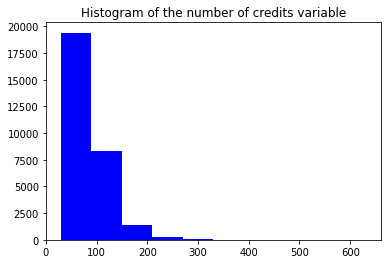

In [ ]:
# The studied_credits variable goes from 30 to 630
plt.hist(dataset.studied_credits, color='blue')
plt.title('Histogram of the number of credits variable')
plt.show()

In [ ]:
# Create a categorical variable based on the studied_credits variable
category = pd.cut(dataset.studied_credits,bins=[0,50,100,150,200,300,700],labels=['0-50','50-100','100-150','150-200','200-300','>300'], include_lowest=True)
dataset.insert(10,'credit_group',category)
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,credit_group,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days,percentclicks_group,days_group,percent_clicks,avg_grade_group,avg_grade,avg_clicks_group,avg_clicks
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,200-300,N,Pass,-159.0,NaN,710.0,500-1000,29.0,20-30,25-50,20.740741,80-90,81.000000,20-30,24.482759
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,50-100,N,Pass,-53.0,NaN,986.0,500-1000,50.0,30-40,25-50,31.851852,60-70,69.333333,10-20,19.720000
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,50-100,Y,Withdrawn,-92.0,12.0,281.0,0-500,12.0,0-10,0-25,4.444444,Not available,NaN,20-30,23.416667
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,50-100,N,Pass,-52.0,NaN,1382.0,1000-1500,75.0,50-60,50-75,51.851852,70-80,72.333333,10-20,18.426667
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,50-100,N,Pass,-176.0,NaN,799.0,500-1000,47.0,20-30,25-50,28.888889,50-60,54.000000,10-20,17.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,0-50,N,Fail,-4.0,NaN,41.0,0-500,5.0,0-10,0-25,2.952030,Not available,NaN,0-10,8.200000
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,0-50,N,Distinction,-23.0,NaN,304.0,0-500,18.0,10-20,0-25,13.284133,80-90,87.000000,10-20,16.888889
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,0-50,Y,Pass,-129.0,NaN,132.0,0-500,11.0,0-10,0-25,7.380074,60-70,65.000000,10-20,12.000000
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,0-50,N,Withdrawn,-49.0,101.0,275.0,0-500,13.0,0-10,0-25,8.118081,90-100,91.500000,20-30,21.153846


### Cutoff date

In [ ]:
# Get the cutoff date from s_vle
cutoff_date_group = s_vle.groupby([s_vle.code_module, s_vle.code_presentation, s_vle.id_student]).cutoff_date.mean()

# Remove the hierarchical index to get a standard table
cutoff_date_group = cutoff_date_group.reset_index()
cutoff_date_group

,code_module,code_presentation,id_student,cutoff_date
0,AAA,2013J,11391,134.0
1,AAA,2013J,28400,134.0
2,AAA,2013J,30268,134.0
3,AAA,2013J,31604,134.0
4,AAA,2013J,32885,134.0
...,...,...,...,...
29199,GGG,2014J,2640965,134.5
29200,GGG,2014J,2645731,134.5
29201,GGG,2014J,2648187,134.5
29202,GGG,2014J,2679821,134.5


In [ ]:
# add cutoff_date to the dataset
dataset = pd.merge(dataset, cutoff_date_group, how='left', on=['code_module', 'code_presentation', 'id_student'])
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,credit_group,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days,percentclicks_group,days_group,percent_clicks,avg_grade_group,avg_grade,avg_clicks_group,avg_clicks,cutoff_date
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,200-300,N,Pass,-159.0,NaN,710.0,500-1000,29.0,20-30,25-50,20.740741,80-90,81.000000,20-30,24.482759,134.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,50-100,N,Pass,-53.0,NaN,986.0,500-1000,50.0,30-40,25-50,31.851852,60-70,69.333333,10-20,19.720000,134.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,50-100,Y,Withdrawn,-92.0,12.0,281.0,0-500,12.0,0-10,0-25,4.444444,Not available,NaN,20-30,23.416667,134.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,50-100,N,Pass,-52.0,NaN,1382.0,1000-1500,75.0,50-60,50-75,51.851852,70-80,72.333333,10-20,18.426667,134.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,50-100,N,Pass,-176.0,NaN,799.0,500-1000,47.0,20-30,25-50,28.888889,50-60,54.000000,10-20,17.000000,134.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,0-50,N,Fail,-4.0,NaN,41.0,0-500,5.0,0-10,0-25,2.952030,Not available,NaN,0-10,8.200000,134.5
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,0-50,N,Distinction,-23.0,NaN,304.0,0-500,18.0,10-20,0-25,13.284133,80-90,87.000000,10-20,16.888889,134.5
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,0-50,Y,Pass,-129.0,NaN,132.0,0-500,11.0,0-10,0-25,7.380074,60-70,65.000000,10-20,12.000000,134.5
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,0-50,N,Withdrawn,-49.0,101.0,275.0,0-500,13.0,0-10,0-25,8.118081,90-100,91.500000,20-30,21.153846,134.5


### Cutoff percent

In [ ]:
# Get the cutoff percent from s_vle
cutoff_percent_group = s_vle.groupby([s_vle.code_module, s_vle.code_presentation, s_vle.id_student]).cutoff_percent.mean()

# Remove the hierarchical index to get a standard table
cutoff_percent_group = cutoff_percent_group.reset_index()
cutoff_percent_group

,code_module,code_presentation,id_student,cutoff_percent
0,AAA,2013J,11391,50
1,AAA,2013J,28400,50
2,AAA,2013J,30268,50
3,AAA,2013J,31604,50
4,AAA,2013J,32885,50
...,...,...,...,...
29199,GGG,2014J,2640965,50
29200,GGG,2014J,2645731,50
29201,GGG,2014J,2648187,50
29202,GGG,2014J,2679821,50


In [ ]:
# add cutoff_percent to the dataset
dataset = pd.merge(dataset, cutoff_percent_group, how='left', on=['code_module', 'code_presentation', 'id_student'])
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,credit_group,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days,percentclicks_group,days_group,percent_clicks,avg_grade_group,avg_grade,avg_clicks_group,avg_clicks,cutoff_date,cutoff_percent
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,200-300,N,Pass,-159.0,NaN,710.0,500-1000,29.0,20-30,25-50,20.740741,80-90,81.000000,20-30,24.482759,134.0,50.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,50-100,N,Pass,-53.0,NaN,986.0,500-1000,50.0,30-40,25-50,31.851852,60-70,69.333333,10-20,19.720000,134.0,50.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,50-100,Y,Withdrawn,-92.0,12.0,281.0,0-500,12.0,0-10,0-25,4.444444,Not available,NaN,20-30,23.416667,134.0,50.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,50-100,N,Pass,-52.0,NaN,1382.0,1000-1500,75.0,50-60,50-75,51.851852,70-80,72.333333,10-20,18.426667,134.0,50.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,50-100,N,Pass,-176.0,NaN,799.0,500-1000,47.0,20-30,25-50,28.888889,50-60,54.000000,10-20,17.000000,134.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,0-50,N,Fail,-4.0,NaN,41.0,0-500,5.0,0-10,0-25,2.952030,Not available,NaN,0-10,8.200000,134.5,50.0
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,0-50,N,Distinction,-23.0,NaN,304.0,0-500,18.0,10-20,0-25,13.284133,80-90,87.000000,10-20,16.888889,134.5,50.0
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,0-50,Y,Pass,-129.0,NaN,132.0,0-500,11.0,0-10,0-25,7.380074,60-70,65.000000,10-20,12.000000,134.5,50.0
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,0-50,N,Withdrawn,-49.0,101.0,275.0,0-500,13.0,0-10,0-25,8.118081,90-100,91.500000,20-30,21.153846,134.5,50.0


### Registration date categoricals

In [ ]:
dataset.date_registration.describe()

count    29486.000000
mean       -66.619345
std         47.677997
min       -311.000000
25%        -95.000000
50%        -53.000000
75%        -29.000000
max        167.000000
Name: date_registration, dtype: float64

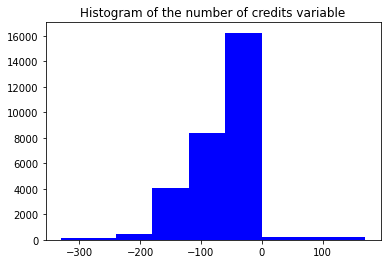

In [ ]:
plt.hist(dataset.date_registration, color='blue', bins=[-330,-240,-180,-120,-60,0, 170])
plt.title('Histogram of the number of credits variable')
plt.show()

In [ ]:
category = pd.cut(dataset.date_registration,bins=[-330,-240,-180,-120,-60,0, 170],labels=['>240 days before','180-240 days before','120-180 days before','60-120 days before','0-60 days before','after term start'], include_lowest=True)
dataset.insert(10,'registration_group',category)
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,registration_group,credit_group,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days,percentclicks_group,days_group,percent_clicks,avg_grade_group,avg_grade,avg_clicks_group,avg_clicks,cutoff_date,cutoff_percent
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,120-180 days before,200-300,N,Pass,-159.0,NaN,710.0,500-1000,29.0,20-30,25-50,20.740741,80-90,81.000000,20-30,24.482759,134.0,50.0
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,0-60 days before,50-100,N,Pass,-53.0,NaN,986.0,500-1000,50.0,30-40,25-50,31.851852,60-70,69.333333,10-20,19.720000,134.0,50.0
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,60-120 days before,50-100,Y,Withdrawn,-92.0,12.0,281.0,0-500,12.0,0-10,0-25,4.444444,Not available,NaN,20-30,23.416667,134.0,50.0
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,0-60 days before,50-100,N,Pass,-52.0,NaN,1382.0,1000-1500,75.0,50-60,50-75,51.851852,70-80,72.333333,10-20,18.426667,134.0,50.0
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,120-180 days before,50-100,N,Pass,-176.0,NaN,799.0,500-1000,47.0,20-30,25-50,28.888889,50-60,54.000000,10-20,17.000000,134.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29491,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,0-60 days before,0-50,N,Fail,-4.0,NaN,41.0,0-500,5.0,0-10,0-25,2.952030,Not available,NaN,0-10,8.200000,134.5,50.0
29492,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,0-60 days before,0-50,N,Distinction,-23.0,NaN,304.0,0-500,18.0,10-20,0-25,13.284133,80-90,87.000000,10-20,16.888889,134.5,50.0
29493,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,120-180 days before,0-50,Y,Pass,-129.0,NaN,132.0,0-500,11.0,0-10,0-25,7.380074,60-70,65.000000,10-20,12.000000,134.5,50.0
29494,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,0-60 days before,0-50,N,Withdrawn,-49.0,101.0,275.0,0-500,13.0,0-10,0-25,8.118081,90-100,91.500000,20-30,21.153846,134.5,50.0


## Check for NaN values in the variables
Handle NaN values in the variables

In [ ]:
# How many NaN by column
columns_name = dataset.columns.tolist()

for column in columns_name:
  sum_null = dataset[column].isnull().sum()
  print(f"{column}: {sum_null} null values, {sum_null/29496:.2f}%")
  print()

code_module: 0 null values, 0.00%

code_presentation: 0 null values, 0.00%

id_student: 0 null values, 0.00%

gender: 0 null values, 0.00%

region: 0 null values, 0.00%

highest_education: 0 null values, 0.00%

imd_band: 1054 null values, 0.04%

age_band: 0 null values, 0.00%

num_of_prev_attempts: 0 null values, 0.00%

studied_credits: 0 null values, 0.00%

registration_group: 10 null values, 0.00%

credit_group: 0 null values, 0.00%

disability: 0 null values, 0.00%

final_result: 0 null values, 0.00%

date_registration: 10 null values, 0.00%

date_unregistration: 22521 null values, 0.76%

sum_click: 998 null values, 0.03%

click_group: 998 null values, 0.03%

sum_days: 998 null values, 0.03%

percentclicks_group: 0 null values, 0.00%

days_group: 998 null values, 0.03%

percent_clicks: 0 null values, 0.00%

avg_grade_group: 0 null values, 0.00%

avg_grade: 3743 null values, 0.13%

avg_clicks_group: 0 null values, 0.00%

avg_clicks: 0 null values, 0.00%

cutoff_date: 998 null values,

9 columns have null values. Analysis shows:

- imd_band: Less than half a percent missing. No discernable trend here. We will assume this data is not available for these students, as it relates to poverty and access levels that may not be universally available. We will replace with "Not Available."

- sum_days and days_group. Less than half a percent missing. We will keep only the categorical variable days_group. This variable represents the number of days a student interacted with the VLE. Null values will be replaced by 0, representing a student that did not interacted with the learning system.

- sum_click and click_group. Less than half a percent missing. We will keep only the categorical variable click_group. This variable represents the number of clicks a student made in the VLE. Null values will be replaced by 0, representing a student that did not interacted with the learning system.

- registration_group & date_registration: 9 out of these 10 students either failed or withdrew from their course. They make up an indistinguishable amount of the data so we will remove these students entirely.

- date_unregistration: All NaN values represents students who never withdraw from the course. We will delete this column.

- avg_grade: TBD

- cutoff_date & cutoff_percent: If someone never clicks in the VLE, they don't have a row in the s_vle df and therefore this column does not get transferred over when we merge. These columns will be deleted, anyway.

In [ ]:
# Fix data with NaN values

# Replace NaN values in imd_band
dataset = dataset.fillna(value={'imd_band': "Not Available"})

# replace NaN values in registration_group
# Need to add a category first to avoid an error

dataset['registration_group'] = dataset['registration_group'].cat.add_categories('Not Available')
dataset = dataset.fillna(value={'registration_group': "Not Available"})
dataset.drop(dataset[dataset['registration_group']=="Not Available"].index, inplace=True)

# replace NaN values in percentclicks_group
# Need to add a category first to avoid an error
dataset['percentclicks_group'] = dataset['percentclicks_group'].cat.add_categories('Not Available')
dataset = dataset.fillna(value={'percentclicks_group': "Not Available"})

# replace NaN values in click_group
dataset = dataset.fillna(value={'click_group': '0-500'})

# replace NaN values in days_group
dataset = dataset.fillna(value={'days_group': '0-25'})



In [ ]:
# Check again how many NaN by column
columns_name = dataset.columns.tolist()

for column in columns_name:
  sum_null = dataset[column].isnull().sum()
  print(column,":",sum_null, "null values")

code_module : 0 null values
code_presentation : 0 null values
id_student : 0 null values
gender : 0 null values
region : 0 null values
highest_education : 0 null values
imd_band : 0 null values
age_band : 0 null values
num_of_prev_attempts : 0 null values
studied_credits : 0 null values
registration_group : 0 null values
credit_group : 0 null values
disability : 0 null values
final_result : 0 null values
date_registration : 0 null values
date_unregistration : 22515 null values
sum_click : 989 null values
click_group : 0 null values
sum_days : 989 null values
percentclicks_group : 0 null values
days_group : 0 null values
percent_clicks : 0 null values
avg_grade_group : 0 null values
avg_grade : 3734 null values
avg_clicks_group : 0 null values
avg_clicks : 0 null values
cutoff_date : 989 null values
cutoff_percent : 989 null values


# Separate training, development and test data before EDA
In this section, we separate the training, development, and test data, before we begin to explore the data in the exploratory data analysis section below. We also confirm that the proportion of labels is consistent in each of the three segments of the data. 

In [ ]:
# Shuffle the rows of the dataset
# Used ramdom_state for reproducibility and to end up with the same order all the time
# Note: each time you run this cell, you'll re-shuffle the data, resulting in a different ordering. Run only once to avoid mixing training, development and test data.
dataset = dataset.sample(frac=1, random_state=12345).reset_index(drop=True)
dataset

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,registration_group,credit_group,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days,percentclicks_group,days_group,percent_clicks,avg_grade_group,avg_grade,avg_clicks_group,avg_clicks,cutoff_date,cutoff_percent
0,BBB,2014B,2534954,F,Wales,Lower Than A Level,0-10%,35-55,3,60,0-60 days before,50-100,Y,Pass,-49.0,NaN,2782.0,2500-3000,108.0,80-90,100-125,88.983051,80-90,80.833333,20-30,25.759259,117.0,50.0
1,GGG,2014J,620826,F,East Anglian Region,Lower Than A Level,80-90%,35-55,0,30,0-60 days before,0-50,Y,Withdrawn,-10.0,104.0,376.0,0-500,17.0,10-20,0-25,12.546125,70-80,72.500000,20-30,22.117647,134.5,50.0
2,FFF,2013J,573900,M,Ireland,Lower Than A Level,Not Available,0-35,0,90,0-60 days before,50-100,N,Pass,-31.0,NaN,2180.0,2000-2500,68.0,40-50,50-75,43.703704,80-90,86.000000,30-40,32.058824,134.0,50.0
3,DDD,2014J,630328,F,West Midlands Region,A Level or Equivalent,20-30%,0-35,0,60,60-120 days before,50-100,N,Pass,-91.0,NaN,232.0,0-500,18.0,10-20,0-25,10.606061,60-70,62.500000,10-20,12.888889,131.0,50.0
4,BBB,2014J,656190,M,Ireland,Lower Than A Level,0-10%,0-35,0,60,60-120 days before,50-100,N,Pass,-108.0,NaN,616.0,500-1000,20.0,10-20,0-25,14.393939,40-50,49.666667,30-40,30.800000,131.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29481,DDD,2013B,235428,M,London Region,Lower Than A Level,20-30%,35-55,0,60,0-60 days before,50-100,N,Withdrawn,-22.0,222.0,819.0,500-1000,37.0,30-40,25-50,30.578512,40-50,40.428571,20-30,22.135135,120.0,50.0
29482,EEE,2014J,1354095,F,South Region,A Level or Equivalent,60-70%,35-55,0,30,0-60 days before,0-50,N,Pass,-25.0,NaN,2070.0,2000-2500,84.0,50-60,75-100,55.350554,80-90,81.333333,20-30,24.642857,134.5,50.0
29483,BBB,2013B,560970,M,Wales,HE Qualification,60-70%,35-55,0,120,0-60 days before,100-150,N,Pass,-19.0,NaN,363.0,0-500,32.0,20-30,25-50,25.619835,80-90,84.000000,10-20,11.343750,120.0,50.0
29484,DDD,2013B,304893,M,North Western Region,A Level or Equivalent,40-50%,0-35,0,120,0-60 days before,100-150,N,Withdrawn,-9.0,224.0,140.0,0-500,22.0,10-20,0-25,18.181818,30-40,31.600000,0-10,6.363636,120.0,50.0


In [ ]:
# Separate training data, development data and test data
# For now we leave data and labels together for EDA

# About 85% of the data in the training data set
train_data = dataset[:25000]

# About 5% of the data in the development data set
dev_data = dataset[25000:26500]

# About 10% of the data in the test data set
test_data = dataset[26500:]

print('train data shape: ', train_data.shape)
print('development data shape: ', dev_data.shape)
print('test data shape: ', test_data.shape)



train data shape:  (25000, 28)
development data shape:  (1500, 28)
test data shape:  (2986, 28)


## Ensure proportion of labels is consistent across datasets
All datasets have a similar proportion of labels.


In [ ]:
dataset.final_result.value_counts(normalize=True)

Pass           0.419182
Withdrawn      0.239537
Fail           0.238723
Distinction    0.102557
Name: final_result, dtype: float64

In [ ]:
train_data.final_result.value_counts(normalize=True)

Pass           0.41720
Withdrawn      0.24004
Fail           0.23928
Distinction    0.10348
Name: final_result, dtype: float64

In [ ]:
dev_data.final_result.value_counts(normalize=True)

Pass           0.428667
Fail           0.239333
Withdrawn      0.235333
Distinction    0.096667
Name: final_result, dtype: float64

In [ ]:
test_data.final_result.value_counts(normalize=True)

Pass           0.431011
Withdrawn      0.237441
Fail           0.233758
Distinction    0.097790
Name: final_result, dtype: float64

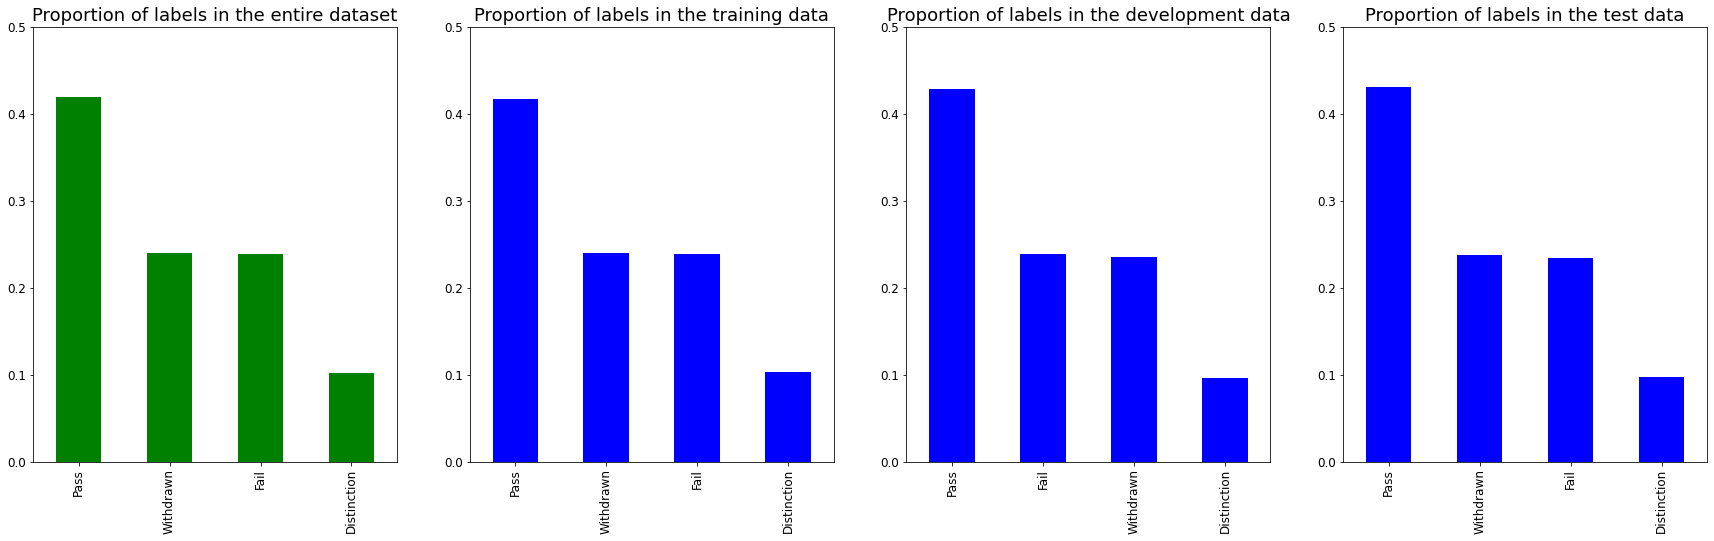

In [ ]:
fig , ax= plt.subplots(nrows=1, ncols=4, figsize=(30, 8))

dataset.final_result.value_counts(normalize=True).plot(kind='bar', color='green', ax=ax[0])
ax[0].set_title('Proportion of labels in the entire dataset', size=18)
ax[0].set_ylim([0,0.5])
ax[0].tick_params(axis='both', which='major', labelsize=12)

train_data.final_result.value_counts(normalize=True).plot(kind='bar', color='blue', ax=ax[1])
ax[1].set_title('Proportion of labels in the training data', size=18)
ax[1].set_ylim([0,0.5])
ax[1].tick_params(axis='both', which='major', labelsize=12)

dev_data.final_result.value_counts(normalize=True).plot(kind='bar', color='blue', ax=ax[2])
ax[2].set_title('Proportion of labels in the development data', size=18)
ax[2].set_ylim([0,0.5])
ax[2].tick_params(axis='both', which='major', labelsize=12)

test_data.final_result.value_counts(normalize=True).plot(kind='bar', color='blue', ax=ax[3])
ax[3].set_title('Proportion of labels in the test data', size=18)
ax[3].set_ylim([0,0.5])
ax[3].tick_params(axis='both', which='major', labelsize=12)
plt.show()


# Exploratory Data Analysis (EDA)
This section includes visualizations of the training data.

We started with seven datasets:

- Assessments: test weights, associated course
- Courses: semester, course code
- StudentAssessment: date submitted, grade
- StudentInfo: demographic information
- StudentRegistration: credits taken
- StudentVLE: interaction with the course
- VLE: overall environment information

After cleaning the data and creating variables of interest, our main dataset looks like this:

In [ ]:
#@title
train_data.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,registration_group,credit_group,disability,final_result,date_registration,date_unregistration,sum_click,click_group,sum_days,percentclicks_group,days_group,percent_clicks,avg_grade_group,avg_grade,avg_clicks_group,avg_clicks,cutoff_date,cutoff_percent
0,BBB,2014B,2534954,F,Wales,Lower Than A Level,0-10%,35-55,3,60,0-60 days before,50-100,Y,Pass,-49.0,NaN,2782.0,2500-3000,108.0,80-90,100-125,88.983051,80-90,80.833333,20-30,25.759259,117.0,50.0
1,GGG,2014J,620826,F,East Anglian Region,Lower Than A Level,80-90%,35-55,0,30,0-60 days before,0-50,Y,Withdrawn,-10.0,104.0,376.0,0-500,17.0,10-20,0-25,12.546125,70-80,72.500000,20-30,22.117647,134.5,50.0
2,FFF,2013J,573900,M,Ireland,Lower Than A Level,Not Available,0-35,0,90,0-60 days before,50-100,N,Pass,-31.0,NaN,2180.0,2000-2500,68.0,40-50,50-75,43.703704,80-90,86.000000,30-40,32.058824,134.0,50.0
3,DDD,2014J,630328,F,West Midlands Region,A Level or Equivalent,20-30%,0-35,0,60,60-120 days before,50-100,N,Pass,-91.0,NaN,232.0,0-500,18.0,10-20,0-25,10.606061,60-70,62.500000,10-20,12.888889,131.0,50.0
4,BBB,2014J,656190,M,Ireland,Lower Than A Level,0-10%,0-35,0,60,60-120 days before,50-100,N,Pass,-108.0,NaN,616.0,500-1000,20.0,10-20,0-25,14.393939,40-50,49.666667,30-40,30.800000,131.0,50.0


#### There are 29,496 individual unique student and semester pairs across 7 course modules.


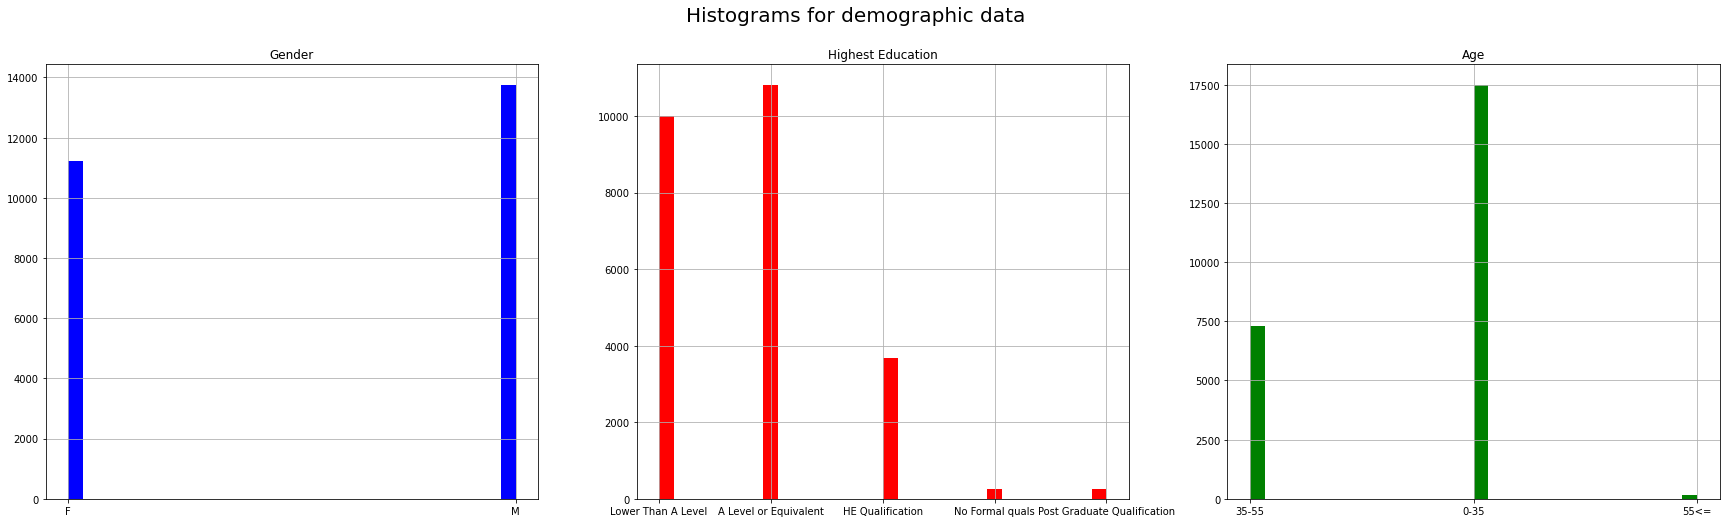

In [ ]:
#@title
# Histograms for demographic data

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 8))

fig.suptitle('Histograms for demographic data', fontsize=20)

# plot histogram for gender
train_data['gender'].hist(bins=30, ax=ax[0], color='blue')
ax[0].set_title('Gender', size =12)
# plot histogram for highest education
train_data['highest_education'].hist(bins=30, ax=ax[1], color='red')
ax[1].set_title('Highest Education', size =12)
# plot histogram for age band
train_data['age_band'].hist(bins=30, ax=ax[2], color='green')
ax[2].set_title('Age', size =12)

plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


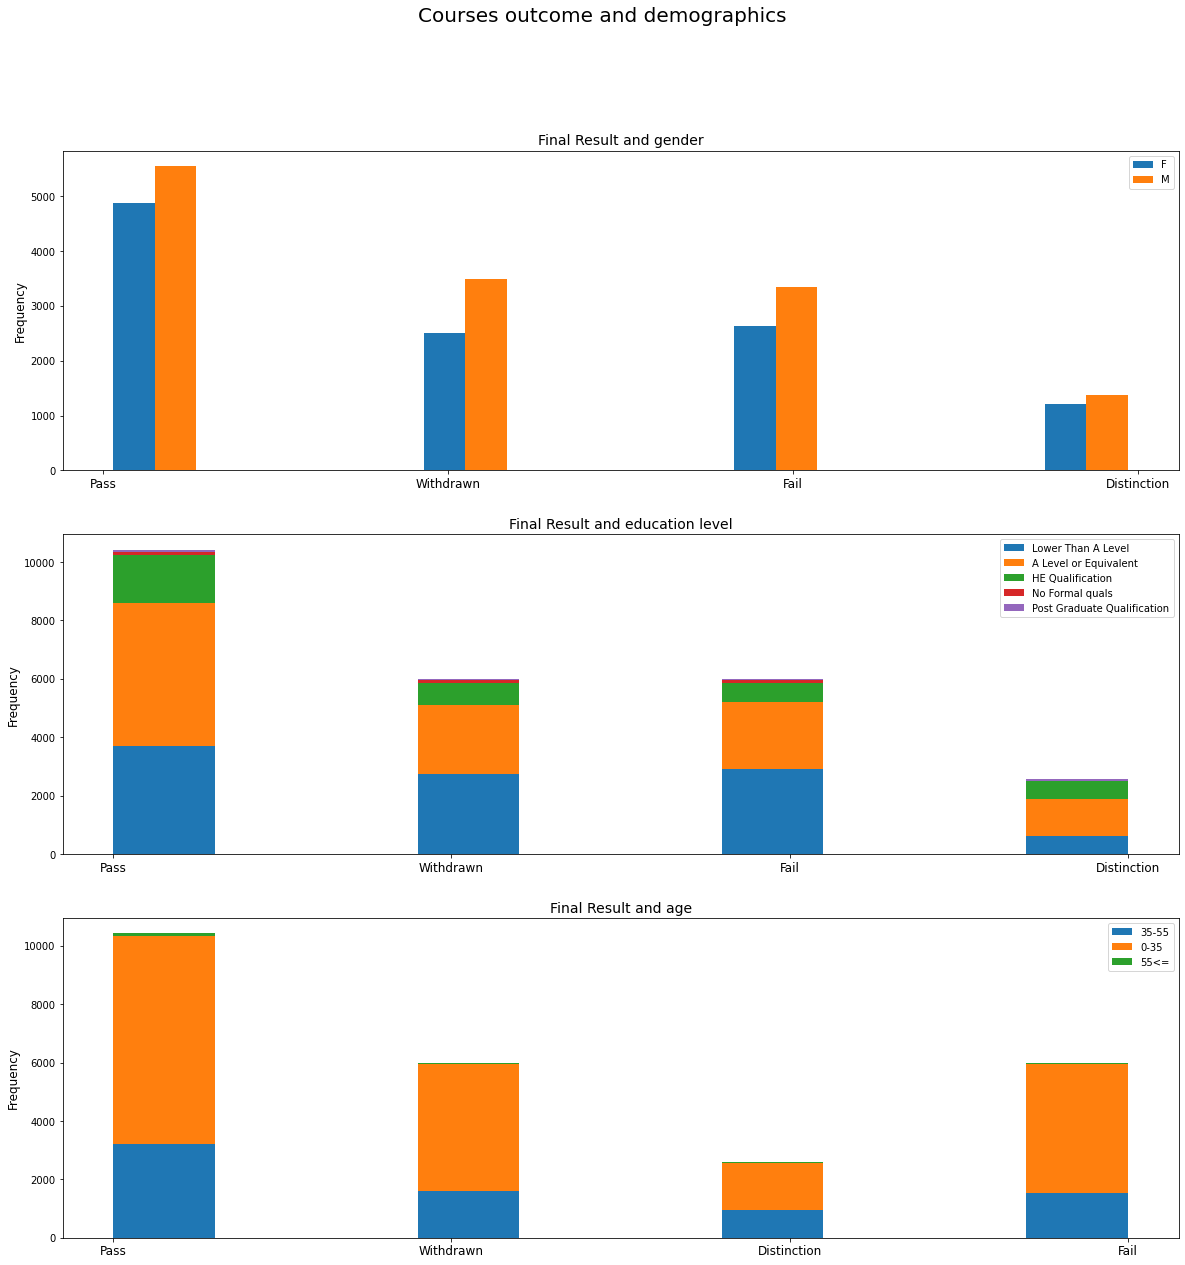

In [ ]:
#@title
# Demographic Histograms considering the outcome result in the courses

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20, 20))

fig.suptitle('Courses outcome and demographics', fontsize=20)

genders = train_data.gender.unique()
ax[0].hist([train_data.loc[train_data.gender == x, 'final_result'] for x in genders], label=genders)
ax[0].legend()
ax[0].set_title('Final Result and gender', size=14)
ax[0].set_ylabel('Frequency', size=12)
ax[0].tick_params(axis='x', labelsize=12)

education = train_data.highest_education.unique()
ax[1].hist([train_data.loc[train_data.highest_education == x, 'final_result'] for x in education], label=education, stacked=True)
ax[1].legend()
ax[1].set_title('Final Result and education level', size=14)
ax[1].set_ylabel('Frequency', size=12)
ax[1].tick_params(axis='x', labelsize=12)

age = train_data.age_band.unique()
ax[2].hist([train_data.loc[train_data.age_band == x, 'final_result'] for x in age], label=age, stacked=True)
ax[2].legend()
ax[2].set_title('Final Result and age', size=14)
ax[2].set_ylabel('Frequency', size=12)
ax[2].tick_params(axis='x', labelsize=12)


plt.show()


 -

-




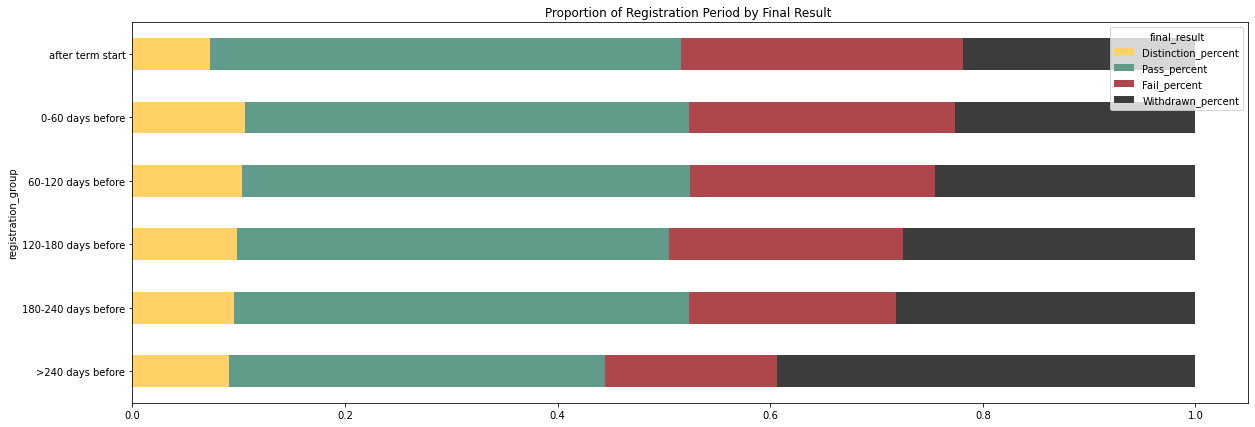

In [ ]:
#@title
# EDA for registration date
table = pd.pivot_table(train_data, values='id_student', index=['registration_group'],
                     columns=['final_result'], aggfunc=np.count_nonzero)
table['total'] = table['Distinction'] + table['Fail'] + table['Pass'] + table['Withdrawn']
table['Distinction_percent'] = table['Distinction']/table['total']
table['Fail_percent'] = table['Fail']/table['total']
table['Pass_percent'] = table['Pass']/table['total']
table['Withdrawn_percent'] = table['Withdrawn']/table['total']
table = table[['Distinction_percent', 'Pass_percent', 'Fail_percent','Withdrawn_percent']]

bar_plot = table.plot(kind='barh',
                      stacked=True,
                      color=['#FFD166', '#619B8A', '#AE474C', '#3C3C3C'],
                      figsize = (20,7),
                      rot=0,
                      fontsize=10,
                      title='Proportion of Registration Period by Final Result '
                      )

-

-

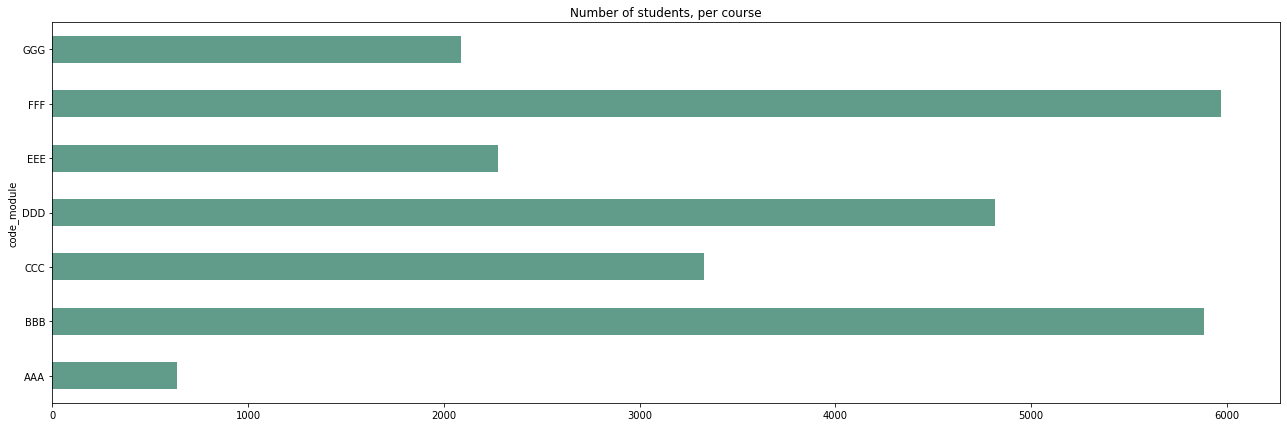

In [ ]:
#@title
table = pd.pivot_table(train_data, values='id_student', index=['code_module'],
                     columns=['final_result'], aggfunc=np.count_nonzero)
table['total'] = table['Distinction'] + table['Fail'] + table['Pass'] + table['Withdrawn']
table

bar_plot = table['total'].plot(kind='barh',
                      
                      color=['#619B8A'],
                      figsize = (22,7),
                      rot=0,
                      fontsize=10,
                      title='Number of students, per course'
                      )

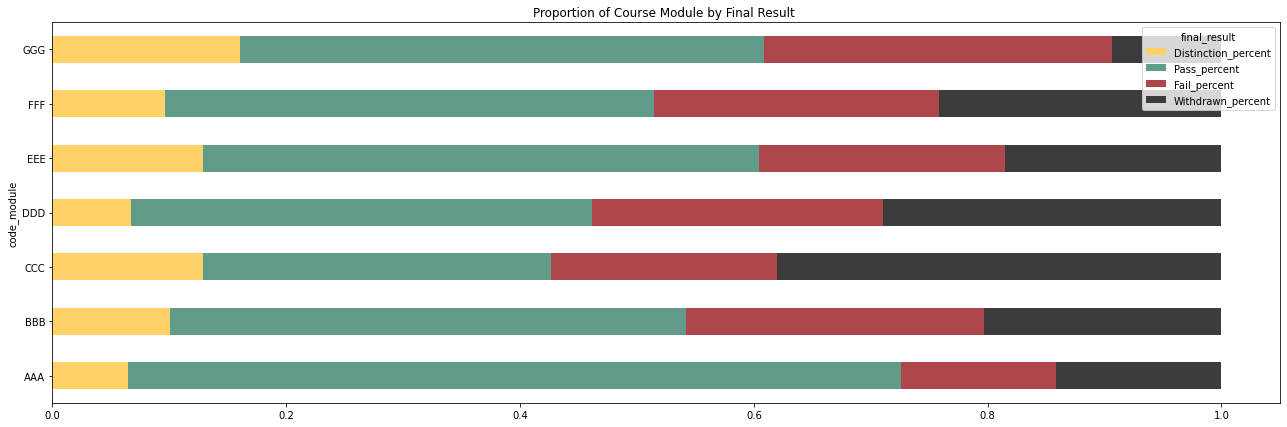

In [ ]:
#@title
table = pd.pivot_table(train_data, values='id_student', index=['code_module'],
                     columns=['final_result'], aggfunc=np.count_nonzero)
table['total'] = table['Distinction'] + table['Fail'] + table['Pass'] + table['Withdrawn']
table['Distinction_percent'] = table['Distinction']/table['total']
table['Fail_percent'] = table['Fail']/table['total']
table['Pass_percent'] = table['Pass']/table['total']
table['Withdrawn_percent'] = table['Withdrawn']/table['total']
table = table[['Distinction_percent', 'Pass_percent', 'Fail_percent','Withdrawn_percent']]

bar_plot = table.plot(kind='barh',
                      stacked=True,
                      color=['#FFD166', '#619B8A', '#AE474C', '#3C3C3C'],
                      figsize = (22,7),
                      rot=0,
                      fontsize=10,
                      title='Proportion of Course Module by Final Result '
                      )

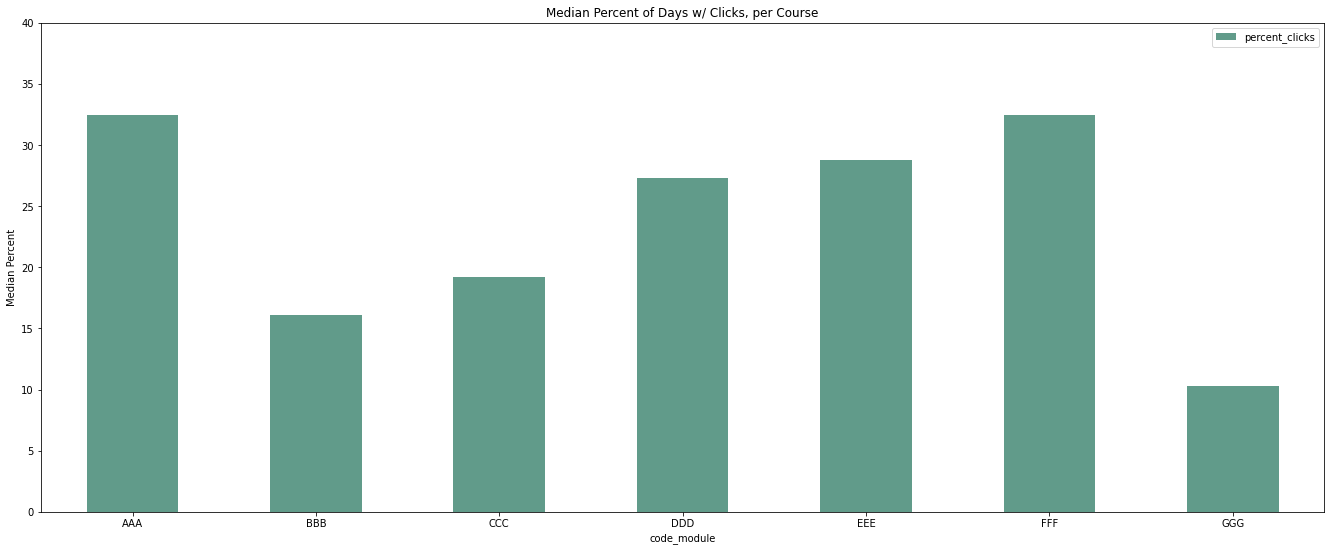

In [ ]:
#@title
table = pd.pivot_table(train_data, values=['percent_clicks'], index=['code_module'],
                      aggfunc=np.median)
bar_plot = table.plot(kind='bar',
                      color=['#619B8A'],
                      figsize = (23,9),
                      rot=0,
                      fontsize=10,
                      ylim=(0,40),
                      title='Median Percent of Days w/ Clicks, per Course',
                      ylabel='Median Percent'
                      )

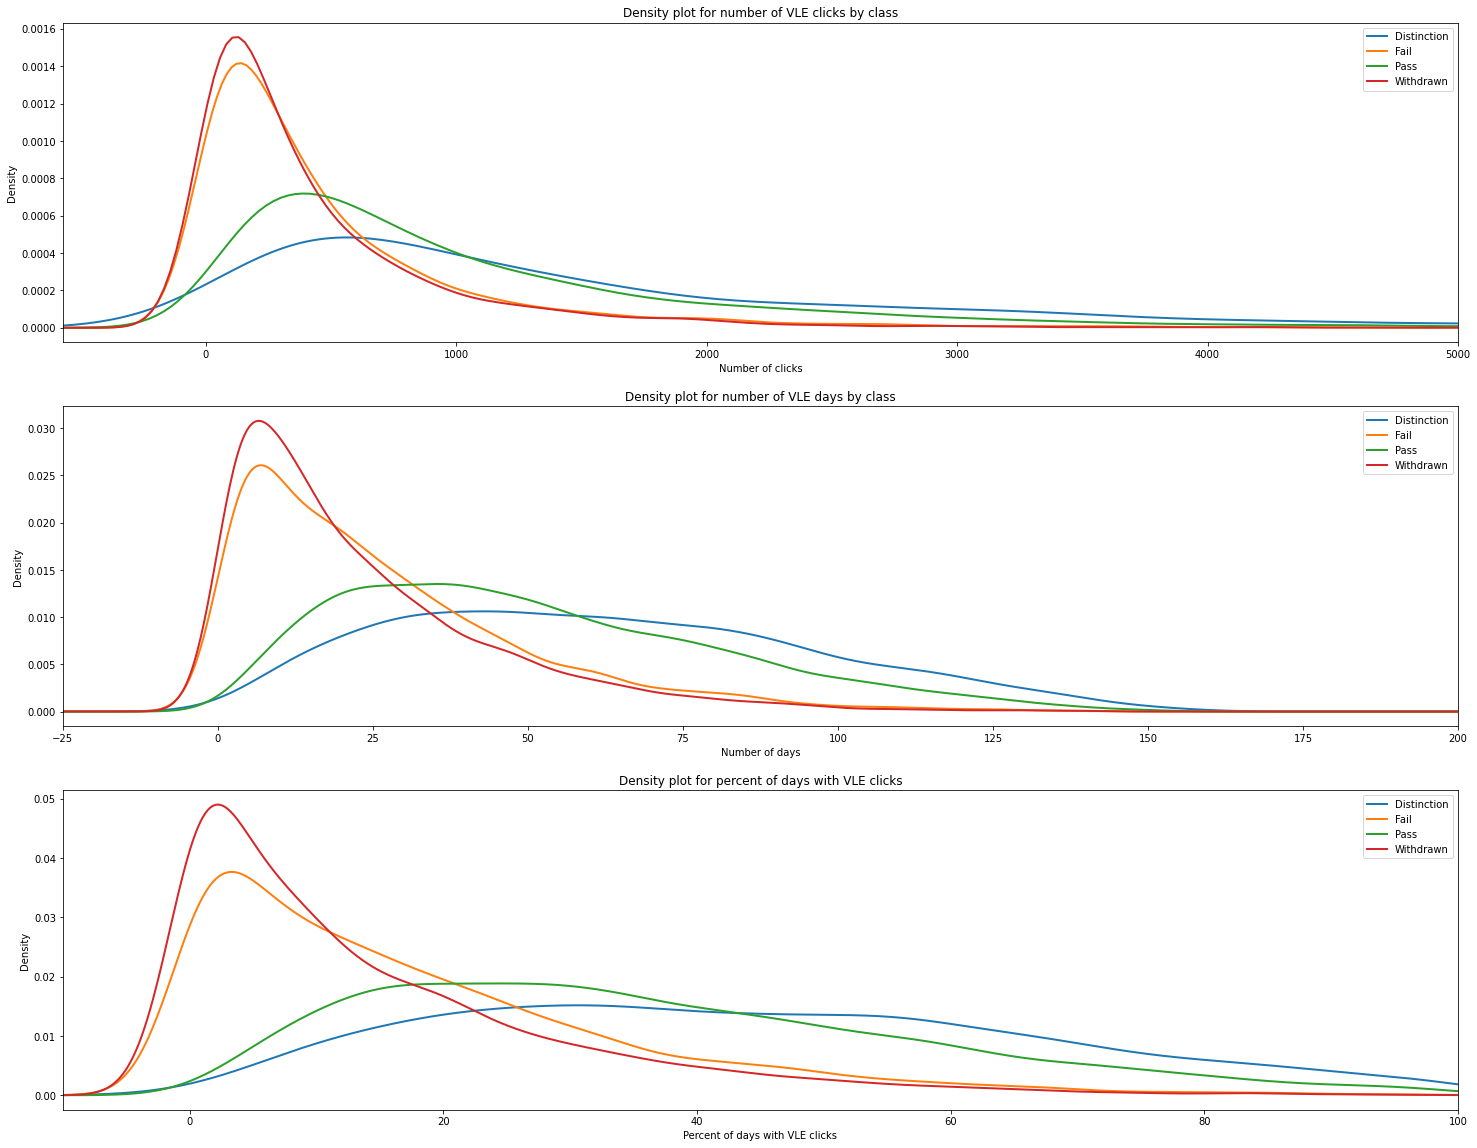

In [ ]:
#@title
# Explore VLE activity by class

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(25, 20))
train_data.groupby('final_result').sum_click.plot(kind='kde', legend=True, ax=ax[0], title='Density plot for number of VLE clicks by class', lw=2, xlim=(-570,5000))
ax[0].set_xlabel("Number of clicks")
train_data.groupby('final_result').sum_days.plot(kind='kde', legend=True, ax=ax[1], title='Density plot for number of VLE days by class', lw=2, xlim=(-25,200))
ax[1].set_xlabel("Number of days")
train_data.groupby('final_result').percent_clicks.plot(kind='kde',legend=True, ax=ax[2], title='Density plot for percent of days with VLE clicks', lw=2, xlim=(-10,100))
ax[2].set_xlabel("Percent of days with VLE clicks")
plt.show()


In [ ]:
# #@title
# # grade distribution throughout term
# fig, ax = plt.subplots(4,1, figsize = (20,12),sharex=True, sharey=False)
# ax[0].hist(train_data.grade_at_25, color='silver', bins=100)
# ax[0].set_title('First Quarter')
# ax[1].hist(train_data.grade_at_50, color='lightsteelblue', bins=100)
# ax[1].set_title('Midterm')
# ax[2].hist(train_data.grade_at_75, color='royalblue', bins=100)
# ax[2].set_title('Third Quarter')
# ax[3].hist(train_data.grade_at_100, color='midnightblue', bins=100)
# ax[3].set_title('Final Grade')
# ax[0].set_xlim(0,100)
# fig.suptitle('Grade Distribution Throughout the Term', fontsize=16)
# plt.show()

In [ ]:
# grades = train_data.avg_grade_group.unique()
# plt.hist([train_data.loc[train_data.avg_grade_group == x, 'final_result'] for x in grades], label=grades)
# plt.title('Courses outcome and grade')
# plt.show()
# plt.figlegend()
# # ax.set_title('Final Result and Grades', size=14)
# # ax.set_ylabel('Frequency', size=12)
# # ax.tick_params(axis='x', labelsize=12)

# Prepare data for modeling
In this section we select the columns we are going to use for modeling, encode and convert to numpy arrays the labels, and binarize the data.


In [ ]:
# The decision tree model uses less features than the other models becuase it results in a higher f-score and overall accuracy.
# Here, we extract a different selection of columns to use in the decision tree.
# It will be binarized in the decision tree model section below.

tree_columns = ['code_module', 'registration_group', 'percentclicks_group', 'disability',
                    'avg_grade_group', 'days_group']

# Extract labels
treetrain_labels = train_data['final_result']
treedev_labels = dev_data['final_result']
treetest_labels = test_data['final_result']

# Select colums in training, development and test datasets
tree_train = train_data[tree_columns]
tree_dev = dev_data[tree_columns]
tree_test = test_data[tree_columns]

treetrain_labels = treetrain_labels.replace(['Withdrawn','Fail','Pass','Distinction'],[0,0,1,1])
treetrain_labels = treetrain_labels.to_numpy()

treedev_labels = treedev_labels.replace(['Withdrawn','Fail','Pass','Distinction'],[0,0,1,1])
treedev_labels = treedev_labels.to_numpy()

treetest_labels = treetest_labels.replace(['Withdrawn','Fail','Pass','Distinction'],[0,0,1,1])
treetest_labels = treetest_labels.to_numpy()

In [ ]:
# The k-NN model uses less features than the other models becuase it ??? 
# Here, we extract a different selection of columns to use. 
# It will not be binarized but be normalized in the K-NN section below. 

nn_columns = ['avg_grade', 'percent_clicks', 'studied_credits', 'num_of_prev_attempts']
# Extract labels
nn_train_labels = train_data['final_result']
nn_dev_labels = dev_data['final_result']
nn_test_labels = test_data['final_result']

# Select colums in training, development and test datasets
nn_train = train_data[nn_columns]
nn_dev = dev_data[nn_columns]
nn_test = test_data[nn_columns]

nn_train_labels = nn_train_labels.replace(['Withdrawn','Fail','Pass','Distinction'],[0,0,1,1])
nn_train_labels = nn_train_labels.to_numpy()

nn_dev_labels = nn_dev_labels.replace(['Withdrawn','Fail','Pass','Distinction'],[0,0,1,1])
nn_dev_labels = nn_dev_labels.to_numpy()

nn_test_labels = nn_test_labels.replace(['Withdrawn','Fail','Pass','Distinction'],[0,0,1,1])
nn_test_labels = nn_test_labels.to_numpy()

In [ ]:
# Drop columns. We dropped continuous variables as we created equivalent categorical variables.
# We also dropped columns that are not features (e.g. 'cutoff_percent' used to pre-process the data) 
# Columns removed: 'id_student', 'studied_credits', 'date_registration', 'date_unregistration', 'sum_click', 'sum_days', 'percent_clicks',
# 'grade_to_date', 'grade_at_25', 'grade_at_50', 'grade_at_75', 'avg_clicks', 'cutoff_date', 'cutoff_percent'
# 'final_result' is also removed as it is the output variable
selected_columns = ['code_module', 'code_presentation', 'gender', 'region', 'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
                    'registration_group', 'credit_group', 'disability', 'click_group', 'percentclicks_group', 'days_group', 'avg_grade_group',
                    'avg_clicks_group']

# Extract labels
train_labels = train_data['final_result']
dev_labels = dev_data['final_result']
test_labels = test_data['final_result']

# Select colums in training, development and test datasets
train_data = train_data[selected_columns]
dev_data = dev_data[selected_columns]
test_data = test_data[selected_columns]

# Print shapes to confirm
print('train data shape: ', train_data.shape)
print('train labels shape: ', train_labels.shape)
print('\ndevelopment data shape: ', dev_data.shape)
print('development labels shape: ', dev_labels.shape)
print('\ntest data shape: ', test_data.shape)
print('test labels shape: ', test_labels.shape)


train data shape:  (25000, 16)
train labels shape:  (25000,)

development data shape:  (1500, 16)
development labels shape:  (1500,)

test data shape:  (2986, 16)
test labels shape:  (2986,)


In [ ]:
# Check for NaN
print('Are there NaN values in the training data?: ', train_data.isnull().values.any())
print('Are there NaN values in the training labels?: ', train_labels.isnull().values.any())
print('Are there NaN values in the development data?: ', dev_data.isnull().values.any())
print('Are there NaN values in the develpment labels?: ', dev_labels.isnull().values.any())
print('Are there NaN values in the test data?: ', test_data.isnull().values.any())
print('Are there NaN values in the test labels?: ', test_labels.isnull().values.any())


Are there NaN values in the training data?:  False
Are there NaN values in the training labels?:  False
Are there NaN values in the development data?:  False
Are there NaN values in the develpment labels?:  False
Are there NaN values in the test data?:  False
Are there NaN values in the test labels?:  False


In [ ]:
# Prepare labels for modeling: encode and convert to numpy arrays
# We are interested in determine if a student succeds or fails. 
# We will combine withdrawn and fail cases to represent cases where students fail.
# We will combine pass and distinction cases to represent cases where students succeed.
# Encode: Withdrawn=0, Fail=0, Pass=1, Distinction=1
# The data will be converted to arrays in the next section after binarizing

train_labels = train_labels.replace(['Withdrawn','Fail','Pass','Distinction'],[0,0,1,1])
train_labels = train_labels.to_numpy()

dev_labels = dev_labels.replace(['Withdrawn','Fail','Pass','Distinction'],[0,0,1,1])
dev_labels = dev_labels.to_numpy()

test_labels = test_labels.replace(['Withdrawn','Fail','Pass','Distinction'],[0,0,1,1])
test_labels = test_labels.to_numpy()

In [ ]:
# Check balance in classes- Classes are balanced
print('\nTraining data')
print('Class=0 {fraction:.2f}'.format(fraction=(len(train_labels) - np.count_nonzero(train_labels)) / len(train_labels)))
print('Class=1 {fraction:.2f}'.format(fraction=np.count_nonzero(train_labels) / len(train_labels)))

print('\nDevelopment data')
print('Class=0 {fraction:.2f}'.format(fraction=(len(dev_labels) - np.count_nonzero(dev_labels)) / len(dev_labels)))
print('Class=1 {fraction:.2f}'.format(fraction=np.count_nonzero(dev_labels) / len(dev_labels)))

print('\nTest data')
print('Class=0 {fraction:.2f}'.format(fraction=(len(test_labels) - np.count_nonzero(test_labels)) / len(test_labels)))
print('Class=1 {fraction:.2f}'.format(fraction=np.count_nonzero(test_labels) / len(test_labels)))


Training data
Class=0 0.48
Class=1 0.52

Development data
Class=0 0.47
Class=1 0.53

Test data
Class=0 0.47
Class=1 0.53


## Binarization of the dataset 
In this section we binarize our variables.


In [ ]:
# Train the OneHotEncoder with the training data
enc=OneHotEncoder()
enc.fit(train_data)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [ ]:
# Print out categories
enc.categories_

[array(['AAA', 'BBB', 'CCC', 'DDD', 'EEE', 'FFF', 'GGG'], dtype=object),
 array(['2013B', '2013J', '2014B', '2014J'], dtype=object),
 array(['F', 'M'], dtype=object),
 array(['East Anglian Region', 'East Midlands Region', 'Ireland',
        'London Region', 'North Region', 'North Western Region',
        'Scotland', 'South East Region', 'South Region',
        'South West Region', 'Wales', 'West Midlands Region',
        'Yorkshire Region'], dtype=object),
 array(['A Level or Equivalent', 'HE Qualification', 'Lower Than A Level',
        'No Formal quals', 'Post Graduate Qualification'], dtype=object),
 array(['0-10%', '10-20', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%',
        '70-80%', '80-90%', '90-100%', 'Not Available'], dtype=object),
 array(['0-35', '35-55', '55<='], dtype=object),
 array([0, 1, 2, 3, 4, 5, 6]),
 array(['0-60 days before', '120-180 days before', '180-240 days before',
        '60-120 days before', '>240 days before', 'after term start'],
       dtype=obje

In [ ]:
# Transform to arrays
train_data_binary = enc.transform(train_data).toarray()
dev_data_binary = enc.transform(dev_data).toarray()
test_data_binary = enc.transform(test_data).toarray()

print('Binary training data shape: ', train_data_binary.shape)
print('Binary development data shape: ', dev_data_binary.shape)
print('Binary test data shape: ', test_data_binary.shape)

Binary training data shape:  (25000, 113)
Binary development data shape:  (1500, 113)
Binary test data shape:  (2986, 113)


# Modeling section
In this section we are going to explore a number of algorithms.
- k-nearest neighbors
- Naive Bayes
- Logistic Regression
- Decision Trees
- Neural Networks


## Logistic Regression
In this section, we use a Logistic model to predict passing or failing grades. We decided to try a Logistic Regression model because the output variable is binary and these models tend to be very flexible, having a wide range of applications.

We built a Logistic regression model that yielded an f-score of 0.796. This model correctly predicts passing grades 85% of the time and failing grades 74% of the time.

In [ ]:
# Initial Logistic regression model
model_lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
model_lr.fit(train_data_binary, train_labels)
pred = model_lr.predict(dev_data_binary)
f_score = metrics.f1_score(dev_labels, pred, average="weighted")
f_score

0.7964815253976825

In [ ]:
# Sensitivities of the regularization parameter C

# Define format to print results in the table
row = "| {C:^7s} | {f_score:^7.3f} |".format

# Print table header
print("\nLogistic regression models")
print("Optimization of C")
print("|    C    | f_score |")
print("-"*21)

# Varying L2 regularization strength (C)
# C is the inverse of regularization strength. Smaller values specify stronger regularization
for i in [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 5, 10, 20, 50]:
    model_lr = LogisticRegression(C=i, solver="liblinear", multi_class="auto")
    # Fit the model with the training data
    model_lr.fit(train_data_binary, train_labels)
    # Predict with the development data
    pred = model_lr.predict(dev_data_binary)
    # Calculate f-score
    f_score = metrics.f1_score(dev_labels, pred, average="weighted")
    # print results to the table
    print(row(C=str(i), f_score=f_score))



Logistic regression models
Optimization of C
|    C    | f_score |
---------------------
| 0.0001  |  0.743  |
|  0.001  |  0.775  |
|  0.01   |  0.793  |
|   0.1   |  0.796  |
|   0.5   |  0.796  |
|    1    |  0.796  |
|    5    |  0.796  |
|   10    |  0.796  |
|   20    |  0.797  |
|   50    |  0.797  |


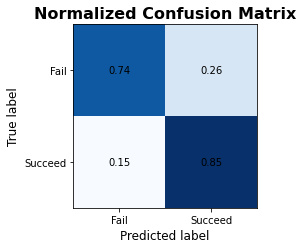

In [ ]:
# Plot a confusion matrix of the model with one of the best f-score (C=0.5)

# Create model 
model_lr = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
model_lr.fit(train_data_binary, train_labels)
pred = model_lr.predict(dev_data_binary)

# Calculate confusion matrix
cm = confusion_matrix(dev_labels, pred, normalize="true")
cm = np.around(cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap="Blues")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix", size=16, weight="bold")
fig.tight_layout()
plt.show()

In [ ]:
model_lr.coef_.shape

(1, 113)

## Decision Trees
In this section, we experiment with the decision tree model which we believe intuitively aligns with our business use and how advisors could understand the model. Initial tests of the decision tree yielded accuracy levels around 65%. An approach with fewer features, used below, resulted in an accuracy of 78.9% with an f score of 0.79.

This model accurately predicts students who will fail to complete the course in 3 out of 4 cases.

In [ ]:
# Because this model uses a version of our dataset with fewer features, we still need to binarize the data.

tree_enc=OneHotEncoder()
tree_enc.fit(tree_train)

tree_enc.categories_

tree_train_binary = tree_enc.transform(tree_train).toarray()
tree_dev_binary = tree_enc.transform(tree_dev).toarray()
tree_test_binary = tree_enc.transform(tree_test).toarray()

# Check sizes of the datasets.
print('Binary training data shape: ', tree_train_binary.shape)
print('Binary development data shape: ', tree_dev_binary.shape)
print('Binary test data shape: ', tree_test_binary.shape)

Binary training data shape:  (25000, 44)
Binary development data shape:  (1500, 44)
Binary test data shape:  (2986, 44)


In [ ]:
# Create a model using the Decision Tree Classifier and the binarized tree dataset.
clf1 = DecisionTreeClassifier(random_state=123)
clf1 = clf1.fit(tree_train_binary, treetrain_labels)
preds1 = clf1.predict(tree_dev_binary)

print(f"This model has an accuracy of {metrics.accuracy_score(treedev_labels, preds1)*100:.2f}%.")

f_score = metrics.f1_score(treedev_labels, preds1, average="weighted")
print(f"This model has an f1 score of {f_score:.4f}.")

This model has an accuracy of 79.00%.
This model has an f1 score of 0.7894.


In [ ]:
#text_representation = tree.export_text(clf)
#print(text_representation)

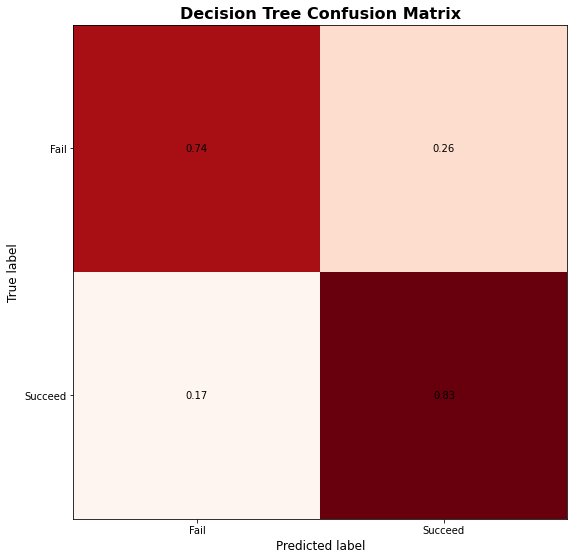

In [ ]:
#@title
# Calculate confusion matrix
cm = confusion_matrix(treedev_labels, preds1, normalize="true")
cm = np.around(cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, cmap="Reds")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Decision Tree Confusion Matrix", size=16, weight="bold")
fig.tight_layout()
plt.show()
plt.show()

## Naive Bayes

In this section, we use a Naive Bayes model to predict passing or failing grades. We decided to try modeling with Naive Bayes because it is simple, fast, and reliable. We found that a Bernoulli Naive Bayes model was 75% accurate at predicting student passing and failing rates. The model was slightly better at predicting passing than failing.

In [ ]:
def find_alpha(alphas):
    row = "| {C:^7s} | {f_score:^7.3f} |".format
    # Print table header
    print("\nNaive Bayes models")
    print("Optimization of Alpha")
    print("|    Alpha    | f_score |")
    print("-"*21)
    for i in alphas:
      model = BernoulliNB(alpha=i)
      # Fit the model with the training data
      model.fit(train_data_binary, train_labels)
      # Predict with the development data
      pred = model.predict(dev_data_binary)
      # Calculate f-score
      f_score = metrics.f1_score(dev_labels, pred, average="weighted")
      # print results to the table
      print(row(C=str(i), f_score=f_score))

alphas = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0,20,30,100,200,250,300,400]
find_alpha(alphas)


Naive Bayes models
Optimization of Alpha
|    Alpha    | f_score |
---------------------
|  1e-10  |  0.750  |
| 0.0001  |  0.750  |
|  0.001  |  0.750  |
|  0.01   |  0.750  |
|   0.1   |  0.750  |
|   0.5   |  0.750  |
|   1.0   |  0.750  |
|   2.0   |  0.750  |
|  10.0   |  0.749  |
|   20    |  0.749  |
|   30    |  0.749  |
|   100   |  0.747  |
|   200   |  0.745  |
|   250   |  0.744  |
|   300   |  0.744  |
|   400   |  0.744  |


In [ ]:
nb_model = BernoulliNB()
nb_model.fit(train_data_binary, train_labels)
dev_predicted_labels = nb_model.predict(dev_data_binary) # predict using model
nb_f1 = metrics.f1_score(dev_labels,dev_predicted_labels, average = 'weighted')
# print("accuracy = " + str(sum(dev_labels == dev_predicted_labels)/len(dev_labels)) + 
#       "%, " + str(sum(dev_labels != dev_predicted_labels)) + " misclassified students")
print('f1 = {0:.4f}'.format(nb_f1))

f1 = 0.7498


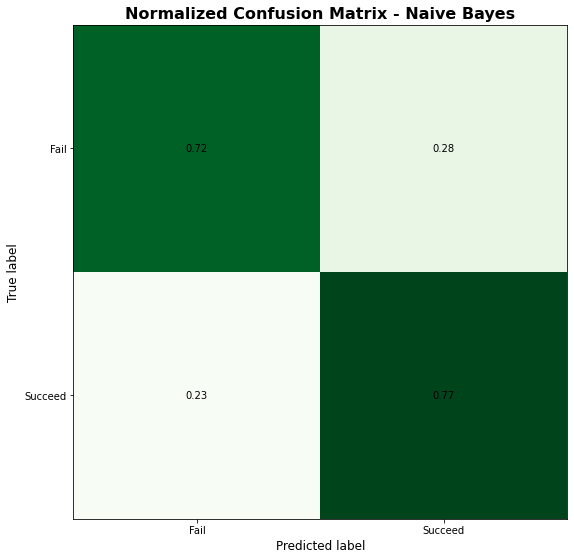

In [ ]:
# Calculate confusion matrix
nb_cm = confusion_matrix(dev_labels, dev_predicted_labels, normalize="true")
nb_cm = np.around(nb_cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(nb_cm, cmap="Greens")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, nb_cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix - Naive Bayes", size=16, weight="bold")
fig.tight_layout()
plt.show()

## K-Nearest Neighbors
In this section, we use a K-Nearest Neighbors model to predict passing or failing. We use K-Nearest Neighbors because it is the simplest algorithms for classification. However, in order to make sure our data is suitable for K-nearest neighbors, we did have to make adjustments to the data like normalizations, reducing features, and using values instead of categorical binarization. 

In order to find an optimal K-NN model, we tried 4 models using different features of the data:
1. All features of binarized data normalized
2. Using normalized value data for avg_grade, percent_clicks, studied_credits. num_of_prev_attempts. In order to account for NaNs we in avg_grade, we set them to 74 or the average of the mean score in the data set. 
3. Using normalized value data for avg_grade, percent_clicks, studied_credits. num_of_prev_attempts. In order to account for NaNs we in avg_grade, we set them to 0. 
4. Using normalized value data for percent_clicks, studied_credits, num_of_prev_attempts. Left out avg_grade altogther. 

We found that model 2 and 3 performed about the same, but found that model 2 was the better model with fail accuracy at 74% and pass accuracy at 80%. We next found the optimal k-value to be 40 with a accuracy of 78% by running a series of models. 

### K-NN Model 1

In [ ]:
norm_train_binary = (train_data_binary-train_data_binary.mean())/train_data_binary.std()
norm_dev_binary = (dev_data_binary-dev_data_binary.mean())/dev_data_binary.std()

In [ ]:
model_nn_1 = KNeighborsClassifier(n_neighbors=40)
model_nn_1.fit(norm_train_binary, train_labels)
predicted_labels = model_nn_1.predict(norm_dev_binary)

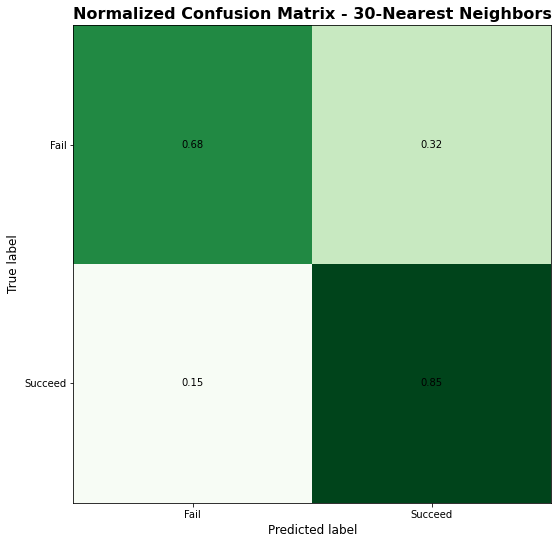

In [ ]:
# Calculate confusion matrix
nn_cm = confusion_matrix(dev_labels, predicted_labels, normalize="true")
nn_cm = np.around(nn_cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(nn_cm, cmap="Greens")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, nn_cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix - 40-Nearest Neighbors", size=16, weight="bold")
fig.tight_layout()
plt.show()

### K-NN Model 2

In [ ]:
nn_train

,avg_grade,percent_clicks,studied_credits,num_of_prev_attempts
0,80.833333,88.983051,60,3
1,72.500000,12.546125,30,0
2,86.000000,43.703704,90,0
3,62.500000,10.606061,60,0
4,49.666667,14.393939,60,0
...,...,...,...,...
24995,95.000000,96.678967,60,0
24996,74.000000,8.888889,180,0
24997,78.125000,61.481481,120,0
24998,89.285714,39.259259,60,0


In [ ]:
nn_train_80 = nn_train.fillna(value={'avg_grade': 74})
nn_dev_80 = nn_dev.fillna(value={'avg_grade': 74 })
nn_train_0 = nn_train.fillna(value={'avg_grade': 0})
nn_dev_0 = nn_dev.fillna(value={'avg_grade': 0 })

In [ ]:
norm_nn_train_80 = (nn_train_80-nn_train_80.mean())/nn_train_80.std()
norm_nn_dev_80 = (nn_dev_80-nn_dev_80.mean())/nn_dev_80.std()
norm_nn_train_0 = (nn_train_0-nn_train_0.mean())/nn_train_0.std()
norm_nn_dev_0 = (nn_dev_0-nn_dev_0.mean())/nn_dev_0.std()

In [ ]:
model_nn_2 = KNeighborsClassifier(n_neighbors=40)
model_nn_2.fit(norm_nn_train_80, train_labels)
predicted_labels_chosen = model_nn_2.predict(norm_nn_dev_80)

In [ ]:
f1_score_nn = metrics.f1_score(dev_labels,predicted_labels_chosen, average = 'weighted')
f1_score_nn

0.7750543298006765

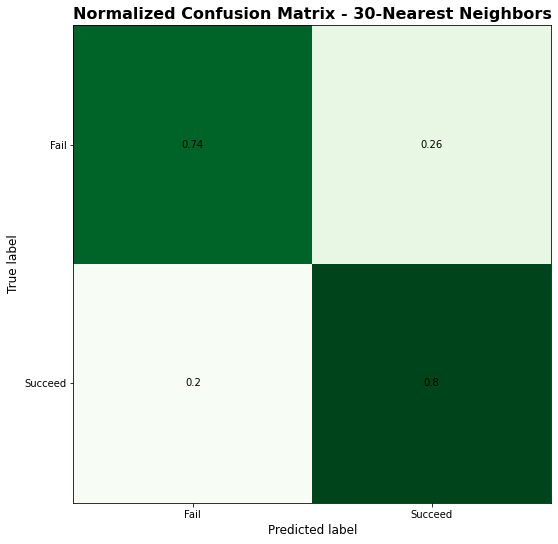

In [ ]:
# Calculate confusion matrix
nn_cm = confusion_matrix(dev_labels, predicted_labels_chosen, normalize="true")
nn_cm = np.around(nn_cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(nn_cm, cmap="Greens")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, nn_cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix - 40-Nearest Neighbors", size=16, weight="bold")
fig.tight_layout()
plt.show()

###K-NN Model 3

In [ ]:
model_nn_3 = KNeighborsClassifier(n_neighbors=40)
model_nn_3.fit(norm_nn_train_0, train_labels)
predicted_labels = model_nn_3.predict(norm_nn_dev_0)

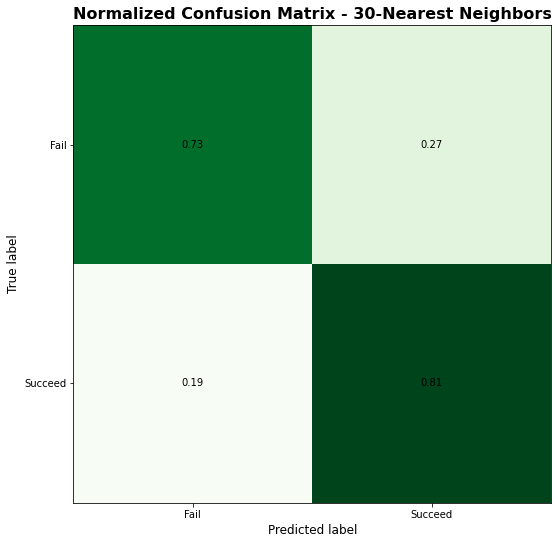

In [ ]:
# Calculate confusion matrix
nn_cm = confusion_matrix(dev_labels, predicted_labels, normalize="true")
nn_cm = np.around(nn_cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(nn_cm, cmap="Greens")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, nn_cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix - 40-Nearest Neighbors", size=16, weight="bold")
fig.tight_layout()
plt.show()

###K-NN Model 4

In [ ]:
norm_train_no_grades = norm_nn_train_0[['num_of_prev_attempts', 'percent_clicks', 'studied_credits']]
norm_dev_no_grades = norm_nn_dev_0[['num_of_prev_attempts', 'percent_clicks', 'studied_credits']]

In [ ]:
model_nn_3 = KNeighborsClassifier(n_neighbors=40)
model_nn_3.fit(norm_train_no_grades, train_labels)
predicted_labels = model_nn_3.predict(norm_dev_no_grades)

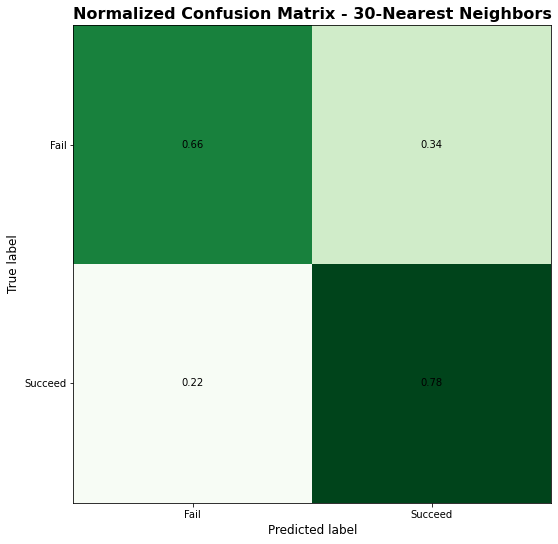

In [ ]:
# Calculate confusion matrix
nn_cm = confusion_matrix(dev_labels, predicted_labels, normalize="true")
nn_cm = np.around(nn_cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(nn_cm, cmap="Greens")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, nn_cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix - 40-Nearest Neighbors", size=16, weight="bold")
fig.tight_layout()
plt.show()

###Finding Optimal K-Value for Model #2

Maximum accuracy:- 0.776 at K = 40


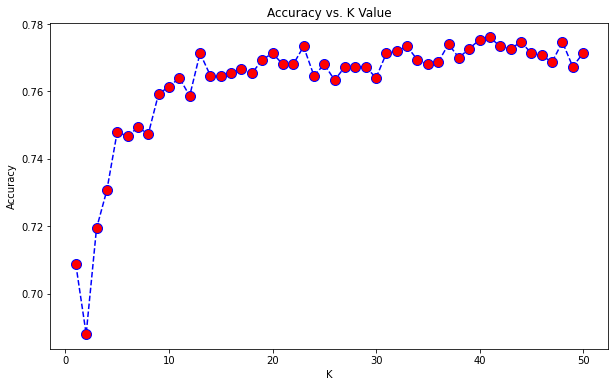

In [ ]:
#Plotting K values vs. accuracy
acc = []
# TAKES A LONG TIME TO RUN MIGHT WANT TO SKIP
for i in range(1,51):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(norm_nn_train_80, train_labels)
    yhat = neigh.predict(norm_nn_dev_80)
    acc.append(metrics.accuracy_score(dev_labels, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,51),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))

## Neural Networks

In this section we experiment with neural networks. We decided to experiment with neural networks because of their flexibility in modeling complex relationships.

We use the Keras python package, which wraps Theano and TensorFlow libraries. We work with one and two hidden layers and generate several models varying hyperparameters such as number of nodes, epochs and batch sizes. We select the best models and create an ensemble of the one-hidden layer models and an ensemble of the two-hidden layers models to make predictions.

An ensemble of one-hidden layer neural network models yielded accuracy levels around 80% and an f-score of 0.801. This ensemble correctly predicts passing grades 86% of the time and failing grades 74% of the time.

An ensemble of two-hidden layer neural network models yielded accuracy levels around 80% and an f-score of 0.807. This ensemble correctly predicts passing grades 86% of the time and failing grades 75% of the time. 

### One hidden layer network

In [ ]:
# Build a loop to try different combinations of number of nodes, epochs and batch sizes.
# All this hyperparameters are subject to optimization, and there is no a clear guide on how to set this parameters
# Because of this we try random combinations of these parameters.

# Number of nodes first hidden layer
n1 = [5, 10, 15, 20, 25, 30]

# Number of epochs
ep = [50, 100, 150]

# batch sizes
bs = [1000, 1500, 2000]

# Initialize variables
best_nodes = 0
best_epoch = 0
best_batch = 0 
best_fscore = 0
best_model_filename = ''
filename = ''

# Initialize lists to make plots
nodes_list = []
epochs_list = []
batch_list = []
fscore_list = []

# remove folder if already created
!rm -rf models

# create directory for models
makedirs('models')

# Initialize counter
i =0

# Sensitivities on parameters
for nodes in n1:
  for epoch in ep:
    for batch in bs:

      # Define the NN model
      # Activation functions:
      # relu:  rectified linear unit activation function
      # sigmoid: sigmoid function. Use a sigmoid on the output layer to ensure the output is between 0 and 1 
      model = Sequential()
      # Define input dimensions and first hidden layer (113 features in the train data)
      # This line of code defines the input layer and the first hidden layer
      model.add(Dense(nodes, input_dim=113, activation='relu'))
      # Output layer
      model.add(Dense(1, activation='sigmoid'))

      # Compile the NN model
      # Loss function: cross entropy for a binary classification problem
      # Optimizer: 'adam'-> stochastic gradient descent algorithm
      # Metrics: accuracy
      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

      # fit the model using the training data
      model.fit(train_data_binary, train_labels, epochs=epoch, batch_size=batch)

      # Make predictions
      pred = model.predict_classes(dev_data_binary)
      # Flatten to have the same shape of the dev_labels array
      pred = pred.flatten()

      # Calculate f-score in the development data
      f_score = metrics.f1_score(dev_labels, pred, average="weighted")

      # save model if f-score is higher than 0.79
      if f_score > 0.79:
        filename = 'models/model_' + str(i + 1) + '.h5'
        model.save(filename)
        i+=1

      # Save parameters and results in lists
      nodes_list.append(nodes)
      epochs_list.append(epoch)
      batch_list.append(batch)
      fscore_list.append(f_score)

      if f_score > best_fscore:
        best_fscore = f_score
        best_nodes = nodes
        best_epoch = epoch
        best_batch = batch 
        best_model_filename = filename

print('best f-score =', best_fscore)
print('best number of nodes =', best_nodes)
print('best number of epochs =', best_epoch)
print('best batch size =', best_batch)
print('best model filename=', filename)
print('number of saved models=', i)

Epoch 1/50
25/25 [==============================] - 1s 3ms/step - loss: 0.6829 - accuracy: 0.5595
Epoch 2/50
25/25 [==============================] - 0s 3ms/step - loss: 0.6402 - accuracy: 0.6688
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.6015 - accuracy: 0.7186
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 0.5707 - accuracy: 0.7385
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.5412 - accuracy: 0.7537
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.5187 - accuracy: 0.7612
Epoch 7/50
25/25 [==============================] - 0s 3ms/step - loss: 0.4974 - accuracy: 0.7709
Epoch 8/50
25/25 [==============================] - 0s 4ms/step - loss: 0.4797 - accuracy: 0.7775
Epoch 9/50
25/25 [==============================] - 0s 3ms/step - loss: 0.4684 - accuracy: 0.7838
Epoch 10/50
25/25 [==============================] - 0s 3ms/step - loss: 0.4609 - accuracy: 0.7842
Epoch 11/50
25/25 [

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Streaming output truncated to the last 5000 lines.
Epoch 54/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4051 - accuracy: 0.8047
Epoch 55/100
25/25 [==============================] - 0s 6ms/step - loss: 0.4080 - accuracy: 0.8005
Epoch 56/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4027 - accuracy: 0.8069
Epoch 57/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4013 - accuracy: 0.8084
Epoch 58/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4037 - accuracy: 0.8065
Epoch 59/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4032 - accuracy: 0.8065
Epoch 60/100
25/25 [==============================] - 0s 5ms/step - loss: 0.3997 - accuracy: 0.8098
Epoch 61/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4071 - accuracy: 0.8039
Epoch 62/100
25/25 [==============================] - 0s 5ms/step - loss: 0.4036 - accuracy: 0.8084
Epoch 63/100
25/25 [=============================

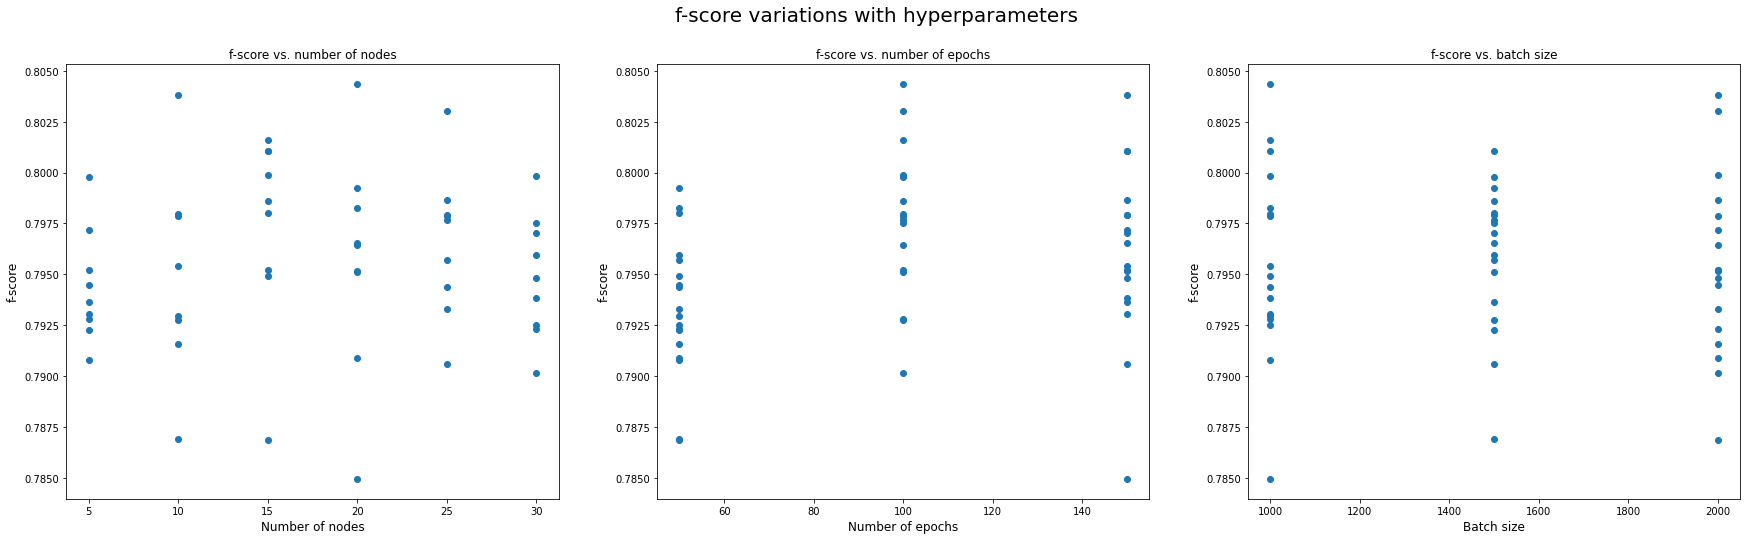

In [ ]:
# Make a plot of results

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30,8))

fig.suptitle('f-score variations with hyperparameters', fontsize=20)
ax[0].scatter(x=nodes_list, y=fscore_list)
ax[0].set_title('f-score vs. number of nodes', size =12)
ax[0].set_xlabel('Number of nodes', size =12)
ax[0].set_ylabel('f-score', size =12)
ax[1].scatter(x=epochs_list, y=fscore_list)
ax[1].set_title('f-score vs. number of epochs', size =12)
ax[1].set_xlabel('Number of epochs', size =12)
ax[1].set_ylabel('f-score', size =12)
ax[2].scatter(x=batch_list, y=fscore_list)
ax[2].set_title('f-score vs. batch size', size =12)
ax[2].set_xlabel('Batch size', size =12)
ax[2].set_ylabel('f-score', size =12)
plt.show()

There is no easy interpretation of the results as the hyperparameters are related in complex ways with the model performance. However, in this case we observe that: 

- 20 nodes produce a model with high f-score. Higher number of nodes (e.g. 30) reduces the performance of some of the models.
- As the number of epochs increase increase from 50 to 100 there are gains in the performance of some models. But  when increasin from 100 to 150 epochs the performance of the models tend to decrease. This is showing possible overfitting.
- No clear trend on batch sizes

Best case:

- best f-score = 0.8043632772166105
- best number of nodes = 20
- best number of epochs = 100
- best batch size = 1000
- best model filename= models/model_51.h5
- number of saved models= 51

#### Essemble of one-layer models

In [ ]:
# Define function to load the saved models 
def load_models(n_models):
  """
  Function to load a number of models saved in the
  models directory, and store them on a list.
  """
  all_models = list()
  for i in range(n_models):
		# define filename 
    filename = 'models/model_' + str(i + 1) + '.h5'
		# load model from file
    model = load_model(filename)
		# add to list of models
    all_models.append(model)
    print('Loaded {f:s}'.format(f=filename))
  return all_models

# i is the counter variable in the loop used to generate the models
# This variable i represents the number of saved models
n_models = i
one_layer_models = load_models(n_models)
print('Loaded {x:d} models'.format(x=len(one_layer_models)))

Loaded models/model_1.h5
Loaded models/model_2.h5
Loaded models/model_3.h5
Loaded models/model_4.h5
Loaded models/model_5.h5
Loaded models/model_6.h5
Loaded models/model_7.h5
Loaded models/model_8.h5
Loaded models/model_9.h5
Loaded models/model_10.h5
Loaded models/model_11.h5
Loaded models/model_12.h5
Loaded models/model_13.h5
Loaded models/model_14.h5
Loaded models/model_15.h5
Loaded models/model_16.h5
Loaded models/model_17.h5
Loaded models/model_18.h5
Loaded models/model_19.h5
Loaded models/model_20.h5
Loaded models/model_21.h5
Loaded models/model_22.h5
Loaded models/model_23.h5
Loaded models/model_24.h5
Loaded models/model_25.h5
Loaded models/model_26.h5
Loaded models/model_27.h5
Loaded models/model_28.h5
Loaded models/model_29.h5
Loaded models/model_30.h5
Loaded models/model_31.h5
Loaded models/model_32.h5
Loaded models/model_33.h5
Loaded models/model_34.h5
Loaded models/model_35.h5
Loaded models/model_36.h5
Loaded models/model_37.h5
Loaded models/model_38.h5
Loaded models/model_3

In [ ]:
# Check accuracy of each model
for model in one_layer_models:
	acc = model.evaluate(dev_data_binary, dev_labels, verbose=0)[1]
	print('Model Accuracy: {acc:.4f}'.format(acc=acc))

Model Accuracy: 0.7920
Model Accuracy: 0.7933
Model Accuracy: 0.7953
Model Accuracy: 0.7940
Model Accuracy: 0.8007
Model Accuracy: 0.7960
Model Accuracy: 0.7940
Model Accuracy: 0.7947
Model Accuracy: 0.7980
Model Accuracy: 0.7933
Model Accuracy: 0.7927
Model Accuracy: 0.7993
Model Accuracy: 0.7940
Model Accuracy: 0.7987
Model Accuracy: 0.7967
Model Accuracy: 0.7987
Model Accuracy: 0.8047
Model Accuracy: 0.7953
Model Accuracy: 0.7987
Model Accuracy: 0.8027
Model Accuracy: 0.7993
Model Accuracy: 0.8007
Model Accuracy: 0.8020
Model Accuracy: 0.8020
Model Accuracy: 0.7960
Model Accuracy: 0.7987
Model Accuracy: 0.8000
Model Accuracy: 0.7920
Model Accuracy: 0.8053
Model Accuracy: 0.7960
Model Accuracy: 0.7973
Model Accuracy: 0.7973
Model Accuracy: 0.7960
Model Accuracy: 0.7947
Model Accuracy: 0.7967
Model Accuracy: 0.7940
Model Accuracy: 0.7987
Model Accuracy: 0.7987
Model Accuracy: 0.8040
Model Accuracy: 0.7987
Model Accuracy: 0.7913
Model Accuracy: 0.7993
Model Accuracy: 0.7927
Model Accur

In [ ]:
# Make an ensemble for prediction 
def ensemble_predictions(models, test_data):
  # make predictions
  pred = [model.predict_classes(test_data) for model in models]
  pred = np.array(pred)
  # sum across ensemble models
  summed = np.sum(pred, axis=0).flatten()
  # Predict with all models. If majority of models vote class 1 then is class 1. 
  # All models have the same weight because all models have more or less the same f-score
  result = np.where(summed > (len(models)/2), 1, 0)
  return result

In [ ]:
# f-score of the ensemble
pred = ensemble_predictions(one_layer_models, dev_data_binary)
f_score = metrics.f1_score(dev_labels, pred, average="weighted")
f_score

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.801111255173342

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


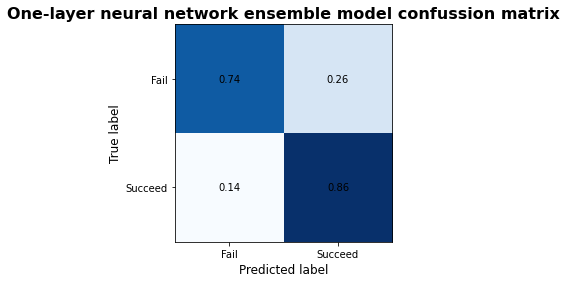

In [ ]:
# Confusion matrix

# Calculate confusion matrix
cm = confusion_matrix(dev_labels, pred, normalize="true")
cm = np.around(cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap="Blues")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("One-layer neural network ensemble model confussion matrix", size=16, weight="bold")
fig.tight_layout()
plt.show()

### Two hidden layers network

In [ ]:
# Build a loop to try different combinations of number of nodes, epochs and batch sizes.
# All this hyperparameters are subject to optimization, and there is no a clear guide on how to set this parameters
# Because of this we try random combinations of these parameters.

# Number of nodes first hidden layer
n1 = [5, 10, 15, 20, 25, 30]

# Reduce the number of nodes on the second hidden layer by dividing by
div = [2, 3, 4]

# Number of epochs
ep = [50, 100, 150]

# batch sizes
bs = [1000, 1500, 2000]

# Initialize variables
best_nodes = 0
best_div = 0
best_epoch = 0
best_batch = 0 
best_fscore = 0
best_model_filename = ''
filename = ''

# Initialize lists to make plots
nodes_list = []
div_list = []
epochs_list = []
batch_list = []
fscore_list = []

# remove folder if already created
!rm -rf models

# create directory for models
makedirs('models')

# Initialize counter
i =0

# Sensitivities on parameters
for nodes in n1:
  for d in div:
    for epoch in ep:
      for batch in bs:

        # Define the NN model
        # Activation functions:
        # relu:  rectified linear unit activation function
        # sigmoid: sigmoid function. Use a sigmoid on the output layer to ensure the output is between 0 and 1 
        model = Sequential()
        # Define input dimensions and first hidden layer (113 features in the train data)
        # This line of code defines the input layer and the first hidden layer
        model.add(Dense(nodes, input_dim=113, activation='relu'))
        # Define second hidden layer
        model.add(Dense(nodes//d, activation='relu'))
        # Output layer
        model.add(Dense(1, activation='sigmoid'))

        # Compile the NN model
        # Loss function: cross entropy for a binary classification problem
        # Optimizer: 'adam'-> stochastic gradient descent algorithm
        # Metrics: accuracy
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        # fit the model using the training data
        model.fit(train_data_binary, train_labels, epochs=epoch, batch_size=batch)

        # Make predictions
        pred = model.predict_classes(dev_data_binary)
        # Flatten to have the same shape of the dev_labels array
        pred = pred.flatten()

        # Calculate f-score in the development data
        f_score = metrics.f1_score(dev_labels, pred, average="weighted")

        # save model if f-score is higher than 0.8. A little higher threshold than in one-layer models
        if f_score > 0.8:
          filename = 'models/model_' + str(i + 1) + '.h5'
          model.save(filename)
          i+=1

        # Save parameters and results in lists
        nodes_list.append(nodes)
        div_list.append(d)
        epochs_list.append(epoch)
        batch_list.append(batch)
        fscore_list.append(f_score)

        if f_score > best_fscore:
          best_fscore = f_score
          best_nodes = nodes
          best_div = d
          best_epoch = epoch
          best_batch = batch 
          best_model_filename = filename

print('best f-score =', best_fscore)
print('best number of nodes =', best_nodes)
print('best number of nodes second hidden layer =', best_nodes // best_div)
print('best number of epochs =', best_epoch)
print('best batch size =', best_batch)
print('best model filename=', filename)
print('number of saved models=', i)

Epoch 1/50
25/25 [==============================] - 1s 6ms/step - loss: 0.6907 - accuracy: 0.5644
Epoch 2/50
25/25 [==============================] - 0s 7ms/step - loss: 0.6611 - accuracy: 0.6407
Epoch 3/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6283 - accuracy: 0.6843
Epoch 4/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5916 - accuracy: 0.7229
Epoch 5/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5485 - accuracy: 0.7426
Epoch 6/50
25/25 [==============================] - 0s 6ms/step - loss: 0.5138 - accuracy: 0.7535
Epoch 7/50
25/25 [==============================] - 0s 6ms/step - loss: 0.4866 - accuracy: 0.7678
Epoch 8/50
25/25 [==============================] - 0s 6ms/step - loss: 0.4663 - accuracy: 0.7784
Epoch 9/50
25/25 [==============================] - 0s 5ms/step - loss: 0.4547 - accuracy: 0.7832
Epoch 10/50
25/25 [==============================] - 0s 5ms/step - loss: 0.4490 - accuracy: 0.7848
Epoch 11/50
25/25 [

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Streaming output truncated to the last 5000 lines.
25/25 [==============================] - 0s 8ms/step - loss: 0.3827 - accuracy: 0.8208
Epoch 55/100
25/25 [==============================] - 0s 8ms/step - loss: 0.3840 - accuracy: 0.8213
Epoch 56/100
25/25 [==============================] - 0s 9ms/step - loss: 0.3791 - accuracy: 0.8227
Epoch 57/100
25/25 [==============================] - 0s 8ms/step - loss: 0.3799 - accuracy: 0.8223
Epoch 58/100
25/25 [==============================] - 0s 8ms/step - loss: 0.3821 - accuracy: 0.8166
Epoch 59/100
25/25 [==============================] - 0s 9ms/step - loss: 0.3809 - accuracy: 0.8190
Epoch 60/100
25/25 [==============================] - 0s 8ms/step - loss: 0.3767 - accuracy: 0.8236
Epoch 61/100
25/25 [==============================] - 0s 7ms/step - loss: 0.3833 - accuracy: 0.8212
Epoch 62/100
25/25 [==============================] - 0s 7ms/step - loss: 0.3783 - accuracy: 0.8238
Epoch 63/100
25/25 [==============================] - 0s 6ms/s

#### Ensemble of two-hidden layer models

In [ ]:
# i is the counter variable in the loop used to generate the models
# This variable i represents the number of saved models
n_models = i
two_layer_models = load_models(n_models)
print('Loaded {x:d} models'.format(x=len(two_layer_models)))

Loaded models/model_1.h5
Loaded models/model_2.h5
Loaded models/model_3.h5
Loaded models/model_4.h5
Loaded models/model_5.h5
Loaded models/model_6.h5
Loaded models/model_7.h5
Loaded models/model_8.h5
Loaded models/model_9.h5
Loaded models/model_10.h5
Loaded models/model_11.h5
Loaded models/model_12.h5
Loaded models/model_13.h5
Loaded models/model_14.h5
Loaded 14 models


In [ ]:
# Check accuracy of each model
for model in two_layer_models:
	acc = model.evaluate(dev_data_binary, dev_labels, verbose=0)[1]
	print('Model Accuracy: {acc:.4f}'.format(acc=acc))

Model Accuracy: 0.8013
Model Accuracy: 0.8027
Model Accuracy: 0.8013
Model Accuracy: 0.8013
Model Accuracy: 0.8020
Model Accuracy: 0.8047
Model Accuracy: 0.8027
Model Accuracy: 0.8013
Model Accuracy: 0.8027
Model Accuracy: 0.8020
Model Accuracy: 0.8027
Model Accuracy: 0.8053
Model Accuracy: 0.8020
Model Accuracy: 0.8013


In [ ]:
# f-score of the ensemble
pred = ensemble_predictions(two_layer_models, dev_data_binary)
f_score = metrics.f1_score(dev_labels, pred, average="weighted")
f_score

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8066117068709306

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


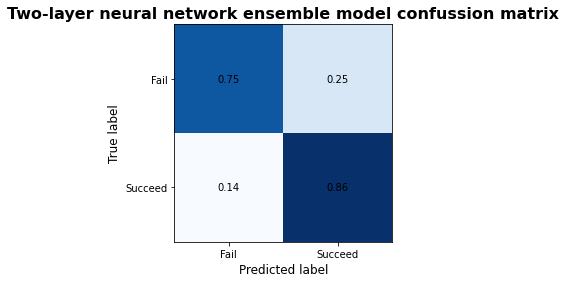

In [ ]:
# Confusion matrix

# Calculate confusion matrix
cm = confusion_matrix(dev_labels, pred, normalize="true")
cm = np.around(cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap="Blues")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Two-layer neural network ensemble model confussion matrix", size=16, weight="bold")
fig.tight_layout()
plt.show()

## Final ensemble of models

In this section we build an ensemble with the models created in the previous sections. So far, the model with the best prediction accuracy is the ensemble of neural networks with two-hidden layers. 

The idea of this section is to see if we can achieve better accuracy in the predictions by using all the models and implementing a simple voting system. The models used in the voting system are shown in the table below:

| Algorithm | Model name | f-score | Pass label accuracy | Fail label accuracy |   
|--- |----------| ------|--- |----------| 
|Logistic regression|model_lr|0.796|85%|74%| 
|Decision Tree|clf1|0.789|83%|74%|
|Naive Bayes|nb_model|0.75|77%|72%|
|k-nearest neighbors|model_nn_2|0.76|79%|74%|
|Ensemble Neural Networks 1-hidden layer|one_layer_models|0.801|86%|74%|
|Ensemble Neural Networks 2-hidden layers|two_layer_models|0.807|86%|75%|

This final ensemble has an f-score of 0.8 and predicts passing grades 85% of the time and failing grades 75% of the time. 

The ensemble of neural networks with two-hidden layers appears to be slightly better, but this final ensemble has great accuracy levels too.

In [ ]:
# Create a dataframe with the predictions of all the models
voting_df = pd.DataFrame()
voting_df['ACTUAL'] = dev_labels
voting_df['LogReg'] = model_lr.predict(dev_data_binary)
voting_df['DecTree'] = clf1.predict(tree_dev_binary)
voting_df['NaiveBayes'] = nb_model.predict(dev_data_binary)
voting_df['KNN'] = model_nn_2.predict(norm_nn_dev_80)
voting_df['NN_ensem_1_layer'] = ensemble_predictions(one_layer_models, dev_data_binary)
voting_df['NN_ensem_2_layers'] = ensemble_predictions(two_layer_models, dev_data_binary)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
voting_df['vote'] = (voting_df.LogReg + voting_df.DecTree + voting_df.NaiveBayes + 
                     voting_df.KNN + voting_df.NN_ensem_1_layer + voting_df.NN_ensem_2_layers)


In [ ]:
# The prediction is 1 if majority of models predict 1
# If tie (=3), the prediction is the prediction of the model with biggest accuracy: 
# ensemble of two-hidden layers neural networks
voting_df['prediction'] = np.where((voting_df['vote'] > 3) | 
                                   ((voting_df['vote'] == 3) & (voting_df['NN_ensem_2_layers'] ==1)), 1, 0)

In [ ]:
voting_df

,ACTUAL,LogReg,DecTree,NaiveBayes,KNN,NN_ensem_1_layer,NN_ensem_2_layers,vote,prediction
0,0,0,1,0,1,1,1,4,1
1,1,1,1,1,1,1,1,6,1
2,0,0,0,0,0,0,0,0,0
3,1,1,0,1,1,1,1,5,1
4,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
1495,1,1,1,1,1,1,1,6,1
1496,1,1,1,1,0,1,1,5,1
1497,0,0,0,0,0,0,0,0,0
1498,0,0,0,0,0,0,0,0,0


In [ ]:
# Calculate f-score

f_score = metrics.f1_score(dev_labels, voting_df.prediction, average="weighted")
f_score

0.7999897242513848

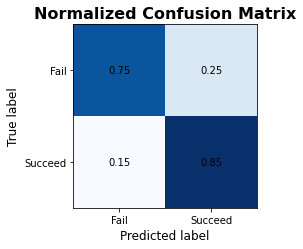

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(dev_labels, voting_df.prediction, normalize="true")
cm = np.around(cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap="Blues")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix", size=16, weight="bold")
fig.tight_layout()
plt.show()

# Predict with test set

To test generalization, in this section we predict test data. We did not use this set of data until this point, so the idea of this is to see how our models respond to unseen data.

Results are shown in the table below:

| Algorithm | f-score | Pass label accuracy | Fail label accuracy |   
|--- |----------| ------|--- |
|Logistic regression|0.813|86%|76%| 
|Decision Tree|0.786|83%|74%|
|Naive Bayes|0.751|77%|73%|
|k-nearest neighbors|0.781|80%|76%|
|Ensemble Neural Networks 1-hidden layer|0.820|87%|77%|
|Ensemble Neural Networks 2-hidden layers|0.824|87%|78%|
|All-models ensemble|0.819|87%|77%|


## Logistic Regression

In [ ]:
# Predict and calculate f-score
pred_logistic_regression = model_lr.predict(test_data_binary)
f_score = metrics.f1_score(test_labels, pred_logistic_regression, average="weighted")
f_score

0.8127314009665197

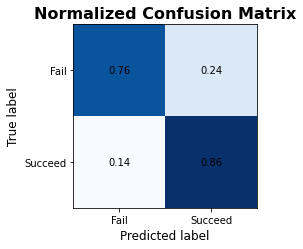

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, pred_logistic_regression, normalize="true")
cm = np.around(cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap="Blues")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix", size=16, weight="bold")
fig.tight_layout()
plt.show()

## Decision Trees

In [ ]:
# Predict and calculate f-score
tree_test_model = clf1.predict(tree_test_binary)
f_score = metrics.f1_score(treetest_labels, tree_test_model, average="weighted")
f_score

0.7862772335642504

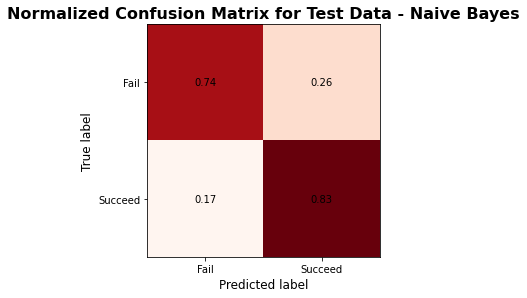

In [ ]:
# Calculate confusion matrix
nb_cm = confusion_matrix(treetest_labels, tree_test_model, normalize="true")
nb_cm = np.around(nb_cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(nb_cm, cmap="Reds")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, nb_cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix for Test Data - Naive Bayes", size=16, weight="bold")
fig.tight_layout()
plt.show()

## Naive Bayes
The Naive Bayes model performed very slightly better on the test data than it did on the development data. The f1 score was 0.7507 for the test data, versus a score of 0.7498 for the development data.

In [ ]:
test_predicted_labels = nb_model.predict(test_data_binary) # predict using model
nb_test_f1 = metrics.f1_score(test_labels,test_predicted_labels, average = 'weighted')
# print("f1 = " + str(nb_test_f1) + 
#       "%, " + str(sum(dev_labels != dev_predicted_labels)) + " misclassified students")
print('f1 = {0:.4f}'.format(nb_test_f1))

f1 = 0.7507


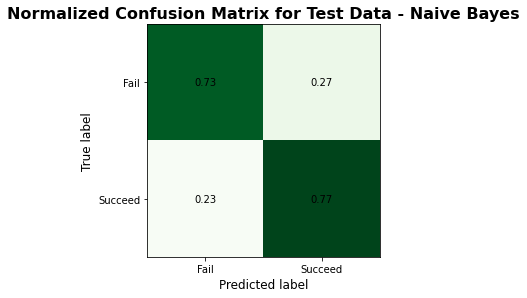

In [ ]:
# Calculate confusion matrix
nb_cm = confusion_matrix(test_labels, test_predicted_labels, normalize="true")
nb_cm = np.around(nb_cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(nb_cm, cmap="Greens")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, nb_cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix for Test Data - Naive Bayes", size=16, weight="bold")
fig.tight_layout()
plt.show()

## K-Nearest Neighbors

In [ ]:
nn_test_80 = nn_test.fillna(value={'avg_grade': 74 })
norm_nn_test_80 = (nn_test_80-nn_test_80.mean())/nn_test_80.std()

In [ ]:
pred_knn_test = model_nn_2.predict(norm_nn_test_80)
f_score = metrics.f1_score(test_labels, pred_knn_test, average="weighted")
f_score

0.781521060996343

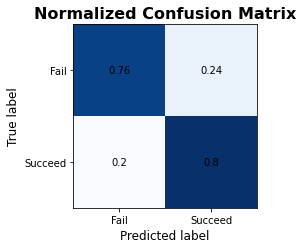

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, pred_knn_test, normalize="true")
cm = np.around(cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap="Blues")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix", size=16, weight="bold")
fig.tight_layout()
plt.show()

## Ensemble of one-hidden layer neural networks

In [ ]:
# Predict and calculate f-score
pred_ensemble_1_layer = ensemble_predictions(one_layer_models, test_data_binary)
f_score = metrics.f1_score(test_labels, pred_ensemble_1_layer, average="weighted")
f_score

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.8201446510136317

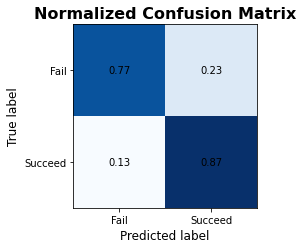

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, pred_ensemble_1_layer, normalize="true")
cm = np.around(cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap="Blues")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix", size=16, weight="bold")
fig.tight_layout()
plt.show()

## Ensemble of two-hidden layers neural networks

In [ ]:
# Predict and calculate f-score
pred_ensemble_2_layers = ensemble_predictions(two_layer_models, test_data_binary)
f_score = metrics.f1_score(test_labels, pred_ensemble_2_layers, average="weighted")
f_score

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.824288117618787

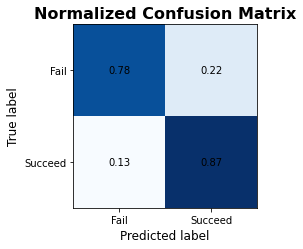

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, pred_ensemble_2_layers, normalize="true")
cm = np.around(cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap="Blues")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix", size=16, weight="bold")
fig.tight_layout()
plt.show()

## All-models ensemble

In [ ]:
# Create a dataframe with the predictions of all the models
voting_test_df = pd.DataFrame()
voting_test_df['ACTUAL'] = test_labels
voting_test_df['LogReg'] = model_lr.predict(test_data_binary)
voting_test_df['DecTree'] = clf1.predict(tree_test_binary)
voting_test_df['NaiveBayes'] = nb_model.predict(test_data_binary)
voting_test_df['KNN'] = model_nn_2.predict(norm_nn_test_80)
voting_test_df['NN_ensem_1_layer'] = ensemble_predictions(one_layer_models, test_data_binary)
voting_test_df['NN_ensem_2_layers'] = ensemble_predictions(two_layer_models, test_data_binary)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
voting_test_df['vote'] = (voting_test_df.LogReg + voting_test_df.DecTree + voting_test_df.NaiveBayes + 
                     voting_test_df.KNN + voting_test_df.NN_ensem_1_layer + voting_test_df.NN_ensem_2_layers)


In [ ]:
# The prediction is 1 if majority of models predict 1
# If tie (=3), the prediction is the prediction of the model with biggest accuracy: 
# ensemble of two-hidden layers neural networks
voting_test_df['prediction'] = np.where((voting_test_df['vote'] > 3) | 
                                   ((voting_test_df['vote'] == 3) & (voting_test_df['NN_ensem_2_layers'] ==1)), 1, 0)

In [ ]:
# Calculate f-score

f_score = metrics.f1_score(test_labels, voting_test_df.prediction, average="weighted")
f_score

0.8198494295387845

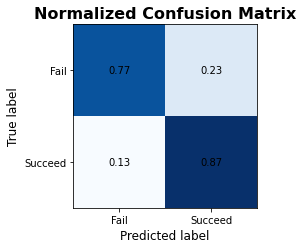

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(test_labels, voting_test_df.prediction, normalize="true")
cm = np.around(cm, 2)

# Plot confusion matrix
axis_labels = ['Fail', 'Succeed']

fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm, cmap="Blues")

# Create the ticks and labels
ax.set_xticks(np.arange(len(axis_labels)))
ax.set_yticks(np.arange(len(axis_labels)))
ax.set_xticklabels(axis_labels)
ax.set_yticklabels(axis_labels)

# Axis titles
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(axis_labels)):
    for j in range(len(axis_labels)):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Normalized Confusion Matrix", size=16, weight="bold")
fig.tight_layout()
plt.show()

In [ ]:
#voting_test_df.to_csv('voting_test.csv', index = False)

#from google.colab import drive
#drive.mount('drive')
#!cp voting_test.csv "drive/My Drive/"


Mounted at drive
